# Mission

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

__Olist__ souhaite que vous fournissiez à ses équipes d'e-commerce une __segmentation des clients__ qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de __comprendre les différents types d’utilisateurs__ grâce à leur comportement et à leurs données personnelles.

Vous devrez __fournir à l’équipe marketing une description actionable__ de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une __proposition de contrat de maintenance__ basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

* La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
* Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

### Livrables
* Un __notebook de l'analyse exploratoire__ (non cleané, pour comprendre votre démarche).
* Un __notebook__ (ou code commenté au choix) __d’essais__ des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
* Un __support de présentation__ pour la soutenance.

### Soutenance
5 min - Présentation de la problématique, de son interprétation et des pistes de recherche envisagées.

5 min - Présentation du cleaning effectué, du feature engineering et de l'exploration.

10 min - Présentation des différentes pistes de modélisation effectuées.

5 min - Présentation du modèle final sélectionné ainsi que des améliorations effectuées.

5 à 10 minutes de questions-réponses.

### Compétences évaluées
* Mettre en place le modèle d'apprentissage non supervisé adapté au problème métier
* Transformer les variables pertinentes d'un modèle d'apprentissage non supervisé
* Adapter les hyperparamètres d'un algorithme non supervisé afin de l'améliorer
* Évaluer les performances d’un modèle d'apprentissage non supervisé

**[About Olist dataset](#About-Olist-dataset)**\
**[Data Schema](#Data-Schema)**

**[I Products Dataset](#I-Products-Dataset)**\
**[II Customers dataset](#II-Customers-dataset)**\
**[III Reviews dataset](#III-Reviews-dataset)**\
**[IV Orders dataset](#IV-Orders-dataset)**\
**[V Order Items dataset](#V-Order-Items-dataset)**\
**[VI Payments dataset](#VI-Payments-dataset)**

**[VII Creation of the final dataset - Towards RFM segmentation](#VII-Creation-of-the-final-dataset---Towards-RFM-segmentation)**\
**[VIII Exploratory Analysis](#VIII-Exploratory-Analysis)**\
[VIII.1 Uni- and bivariate distributions](#VIII.1-Uni--and-bivariate-distributions)\
[VIII.2 Correlations](#VIII.2-Correlations)\
[VIII.3 PCA on product category variables](#VIII.3-PCA-on-product-category-variables)

### About Olist dataset

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

### Data Schema
The data is divided in multiple datasets for better understanding and organization:

![Data schema](./images/schema_datasets.png "Data schema")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from collections import Counter

# custom functions for data analysis
import functions

# feature engineering
from sklearn.decomposition import NMF, PCA

# Clustering
from sklearn import cluster, preprocessing, metrics, mixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Visualization
from sklearn import manifold

A routine to get the default matplotlib style for drawing boxplots

In [2]:
# fonction qui permet de récupérer les paramètres par défaut de matplotlib pour l'affichage des boxplots
def mpl_defaultstyle():
    """Apply Matplotlib default style for boxplots
    
    Returns
    -------
    boxprops, capprops, medianprops
    """
    import matplotlib as mpl
    boxprops = {'facecolor': 'white',
                'edgecolor': 'black',
                'linestyle': mpl.rc_params()['boxplot.boxprops.linestyle'],
                'linewidth': mpl.rc_params()['boxplot.flierprops.linewidth']}
    capprops = {'color': 'black', 'linestyle': '-','linewidth': 1.0}
    medianprops = {'color': 'C1', 'linestyle': '-', 'linewidth': 1.0}
    
    return boxprops, capprops, medianprops

Loading the datasets

In [3]:
customers_data = pd.read_csv('./data/olist_customers_dataset.csv')
geolocation_data = pd.read_csv('./data/olist_geolocation_dataset.csv')
items_data = pd.read_csv('./data/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
payments_data = pd.read_csv('./data/olist_order_payments_dataset.csv')
reviews_data = pd.read_csv('./data/olist_order_reviews_dataset.csv', parse_dates=['review_creation_date', 'review_answer_timestamp'])
orders_data = pd.read_csv('./data/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp',
                                                                          'order_approved_at',
                                                                          'order_delivered_carrier_date',
                                                                          'order_delivered_customer_date',
                                                                          'order_estimated_delivery_date'])
products_data = pd.read_csv('./data/olist_products_dataset.csv')
sellers_data = pd.read_csv('./data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('./data/product_category_name_translation.csv')

### Metadata

Metadata which will help us with the exploratory analysis:
- keys (for merging the datasets)
- variable types, and especially if a variable can be cast to a datetime
- presence and number of missing values
- number of rows, columns
- short description of the datasets

In [4]:
# list of tuples (data, name, (primary key, connected to), (foreign key, connected to), description of dataset)
datasets = [(customers_data, 
             "customer_dataset",
             np.array([("customer_id", "orders_dataset")], dtype='object'),
             np.array([("customer_zip_code_prefix", "geolocation_dataset")], dtype='object'),
             """This dataset has information about the customer and its location. 
                Use it to identify unique customers in the orders dataset and to find the orders delivery location.
                At our system each order is assigned to a unique customerid. 
                This means that the same customer will get different ids for different orders. 
                The purpose of having a customerunique_id on the dataset is to allow you to identify customers 
                that made repurchases at the store. Otherwise you would find that each order had a different 
                customer associated with."""
            ),
            
            (geolocation_data, 
             "geolocation_dataset",
             np.array([("geolocation_zip_code_prefix", ["customer_dataset", "sellers_dataset"])], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset has information Brazilian zip codes and its lat/lng coordinates. 
                Use it to plot maps and find distances between sellers and customers."""
            ),
            
            (items_data,
             "order_items_dataset", 
             np.array([('order_id', 'orders_dataset'), ('order_item_id', np.nan)], dtype='object'), 
             np.array([("product_id", "products_dataset"),("seller_id", "sellers_dataset")], dtype='object'),
             """This dataset includes data about the items purchased within each order."""
            ),
            
            (payments_data, 
             "payments_dataset",
             np.array([('order_id', 'orders_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the orders payment options.""",
            ),
            
            (reviews_data,
             "reviews_dataset",
             np.array([('order_id', 'orders_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the reviews made by the customers. 
                After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. 
                Once the customer receives the product, or the estimated delivery date is due, 
                the customer gets a satisfaction survey by email where he can give a note for 
                the purchase experience and write down some comments."""
            ),
            
            (orders_data, 
             "orders_dataset", 
             np.array([('order_id', ['order_payments_dataset', 'order_items_dataset','order_reviews_dataset']), ('customer_id', 'customer_dataset')], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This is the core dataset. From each order you might find all other information."""
            ),
            
            (products_data,
             "products_dataset", 
             np.array([("product_id", "order_item_dataset")], dtype='object'),
             np.array([(np.nan, np.nan)], dtype='object'),
             """This dataset includes data about the products sold by Olist."""
            ),
            
            (sellers_data, 
             "seller_dataset", 
             np.array([("seller_id", "order_items_dataset")], dtype='object'),
             np.array([("seller_zip_code_prefix", "geolocation_dataset")], dtype='object'),
             """This dataset includes data about the sellers that fulfilled orders made at Olist. 
                Use it to find the seller location and to identify which seller fulfilled each product."""
            )
           ]



dataset = []
column = []
nb_rows = []
NaN = []
nb_rows_na = []
dtype = []
primary_key = []
foreign_key = []
connected_to = []
descriptions = []

for data, name, pk, fk, desc in datasets:
    for c in data.columns:
        dataset.append(name)
        column.append(c)
        nb_rows.append(data[c].shape[0])
        NaN.append(data[c].isna().sum() != 0)
        nb_rows_na.append(data[c].dropna().shape[0])
        try:
            data[c].astype("datetime64")
            dtype.append(np.dtype('datetime64')) 
        except:
            dtype.append(data[c].dtype)
        primary_key.append(True if c in pk[:, 0] else False)
        foreign_key.append(True if c in fk[:, 0] else False)
        connected_to.append(pk[np.where(pk==c)[0], 1][0] if c in pk[:, 0] 
                            else fk[np.where(fk==c)[0], 1][0] if c in fk[:, 0]
                            else np.nan)
        descriptions.append(desc)

meta_dict = {"dataset":dataset,
             "column":column,
             "nb_rows":nb_rows,
             "NaN":NaN,
             "nb_rows_na":nb_rows_na,
             "dtype":dtype,
             "primary_key":primary_key,
             "foreign_key":foreign_key,
             "connected_to":connected_to,
             "description": descriptions
            }

metadata = pd.DataFrame.from_dict(meta_dict)
metadata

,dataset,column,nb_rows,NaN,nb_rows_na,dtype,primary_key,foreign_key,connected_to,description
0,customer_dataset,customer_id,99441,False,99441,object,True,False,orders_dataset,This dataset has information about the custome...
1,customer_dataset,customer_unique_id,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
2,customer_dataset,customer_zip_code_prefix,99441,False,99441,int64,False,True,geolocation_dataset,This dataset has information about the custome...
3,customer_dataset,customer_city,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
4,customer_dataset,customer_state,99441,False,99441,object,False,False,NaN,This dataset has information about the custome...
5,geolocation_dataset,geolocation_zip_code_prefix,1000163,False,1000163,int64,True,False,"[customer_dataset, sellers_dataset]",This dataset has information Brazilian zip cod...
6,geolocation_dataset,geolocation_lat,1000163,False,1000163,float64,False,False,NaN,This dataset has information Brazilian zip cod...
7,geolocation_dataset,geolocation_lng,1000163,False,1000163,float64,False,False,NaN,This dataset has information Brazilian zip cod...
8,geolocation_dataset,geolocation_city,1000163,False,1000163,object,False,False,NaN,This dataset has information Brazilian zip cod...
9,geolocation_dataset,geolocation_state,1000163,False,1000163,object,False,False,NaN,This dataset has information Brazilian zip cod...


Missing values are found in _reviews_dataset_, _orders_dataset_ and _products_dataset_. We choose not to do anything regarding these missing values because the lack of data can always either be logically explained (a missing _review_comment_message_ indicates that no _review_comment_message_ was sent for this specific _review_id_), either explained by the value of an other variable (a missing _order_delivered_customer_date_ reflects the fact that the order was not (yet) delivered to the customer, indicated by the value of _order_status_). On the other hand 

# I Products Dataset

Let us start by inspecting the products dataset

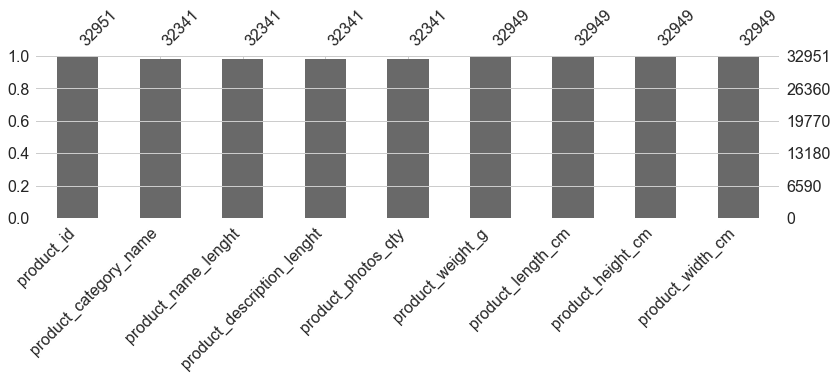

In [282]:
msno.bar(products_data, figsize=(12, 5))
plt.gcf().subplots_adjust(bottom=0.4, top=0.85, left=.07, right=.93)
plt.savefig("./images/products_data.png", dpi=300)

Missing values in the products dataset are problematic: if there is no value for product_category_name, then there is no value for all other variables, except _product_id_. Therefore we might want  to get rid of all items that do not have at least a name. But it turns out not to be necessary, as merging this table with _category_translation_ will automatically remove those items from the newly created table. 

In [5]:
# merging products_data with category_translation
products_data_english = pd.merge(products_data, 
                                 category_translation, 
                                 on='product_category_name').drop(columns=['product_category_name'])
products_data_english.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


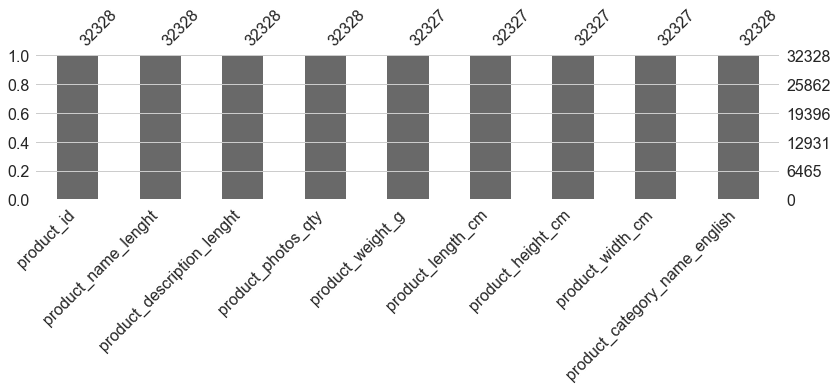

In [285]:
msno.bar(products_data_english, figsize=(12, 5))
plt.gcf().subplots_adjust(bottom=0.45, top=0.85, left=.07, right=.93)
plt.savefig("./images/products_data_english.png", dpi=300)

There are 71 product categories. Since this can be an issue during the processing of the data, we will group them in broader categories.

We will use the following categories:
- home_garden_tools
- food_beverages
- health_beauty_baby
- fashion_clothing
- toys_hobby
- accessories
- music_video_books_stationery
- consumer_electronics
- home_appliances
- furniture
- other

In [6]:
products_data_english["product_category"] = (
 np.where(
     products_data_english["product_category_name_english"].str.contains(
         "perfum|health_beauty|diapers_and_hygiene|baby"),
    "health_beauty_baby",
     
     np.where(
         products_data_english["product_category_name_english"].str.contains(
             "housewares|tools|construction|la_cuisine|home_comfort"),
         "home_garden_tools",
              
          np.where(
              products_data_english["product_category_name_english"].str.contains(
                  "drink"),
              "food_beverages",
              
              np.where(
                  products_data_english["product_category_name_english"].str.contains(
                      "fashio"),
                  "fashion_clothing",
                  
                  np.where(
                      products_data_english["product_category_name_english"].str.contains(
                      "sports_leisure|musical_instruments|toys|consoles_games|cine_photo"),
                      "toys_hobby",
                      
                      np.where(
                          products_data_english["product_category_name_english"].str.contains(
                              "luggage_accessories|watches_gifts|"),
                          "accessories",
                          
                          np.where(
                              products_data_english["product_category_name_english"].str.contains(
                                  "stationery|books|music|dvds|art|"),
                              "music_video_books_stationery",
                              
                              np.where(
                                  products_data_english["product_category_name_english"].str.contains(
                                      "computers|electronics|telephony|"),
                                  "consumer_electronics",
                                  
                                  np.where(
                                      products_data_english["product_category_name_english"].str.contains(
                                      "appliances"),
                                  "home_appliances",
                                   
                                      np.where(
                                              products_data_english["product_category_name_english"]
                                              .str.contains("furniture"),
                                              "furniture",
                                              "other"
                                          )
                                      )
                                  )
                              )
                          )
                      )
                  )
              )
          )
     )
 )

# getting rid of unnecessary columns
products_data_english.drop(columns=["product_name_lenght",
                                     "product_description_lenght",
                                     "product_photos_qty",
                                     "product_weight_g",
                                     "product_length_cm",
                                     "product_height_cm",
                                     "product_width_cm",
                                     "product_category_name_english"], inplace=True)
products_data_english.head()

,product_id,product_category
0,1e9e8ef04dbcff4541ed26657ea517e5,health_beauty_baby
1,6a2fb4dd53d2cdb88e0432f1284a004c,health_beauty_baby
2,0d009643171aee696f4733340bc2fdd0,health_beauty_baby
3,b1eae565a61935e0011ee7682fef9dc9,health_beauty_baby
4,8da90b37f0fb171b4877c124f965b1f6,health_beauty_baby


How are these categories represented in the dataset?

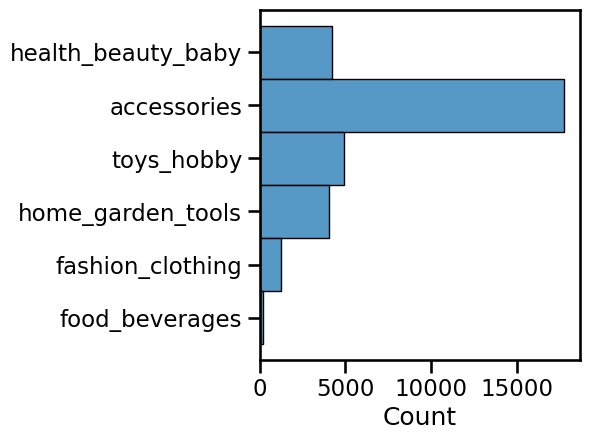

In [29]:
#with sns.axes_style('whitegrid'):
sns.set_context("talk")
fig, ax  = plt.subplots()
sns.histplot(data=products_data_english, y="product_category", linewidth=1, ax=ax)
ax.set_ylabel("")
plt.gcf().subplots_adjust(
                          bottom=0.15,
                          #top=0.85,
                          left=.4,
                          #right=.93
                         )
plt.savefig('./images/product_cats.png', dpi=300)
plt.show()

_accessories_ is by far the most represented category, followed by _health_beauty_baby_, _toys_hobby_ and _home_garden_tools_ almost ex-aequo. Finally, _fashion_clothing_ and last _food_beverages_ are the least represented categories.

# II Customers dataset

Exploration of the customers dataset.

In [8]:
customers_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [9]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [10]:
customers_data.customer_state.unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

Instead of using all 26 states, we want to find a way to cluster these states into only a few broad categories. these categories can be based on density of population and GDP per capita. The data can be found on wikipedia [here](https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product) and [here](https://en.wikipedia.org/wiki/Federative_units_of_Brazil)

In [8]:
# we create a new dataframe containing information on the pop. density and GDP per capita for each state

# the codes for each state
url = "https://en.wikipedia.org/wiki/Federative_units_of_Brazil"
codes = pd.read_html(url)[1]

# GRP per capita
url = "https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product"
grp = pd.read_html(url)[1]


states = (pd.merge(codes[["Flag and name", "Code","Density (perkm2, 2019)"]],
                  grp[["Federative unit", "GRP Per capitain BRL"]],
                  left_on="Flag and name",
                  right_on="Federative unit")
          .rename(columns={"GRP Per capitain BRL":"GRP_capita",
                           "Density (perkm2, 2019)":"density",
                          })
          .drop(columns="Federative unit")
          .set_index(["Flag and name", "Code"])
         )

states

,,density,GRP_capita
Flag and name,Code,,
Acre,AC,6.34,16.837
Alagoas,AL,125.52,14.723
Amapá,AP,2.63,18.329
Amazonas,AM,2.58,22.245
Bahia,BA,30.52,16.931
Ceará,CE,60.33,15.437
Distrito Federal,DF,493.00,79.099
Espírito Santo,ES,80.63,27.487
Goiás,GO,18.46,27.135


Let us group the states by density and GDP per capita. We'll use Agglomerativeclustering to perform the clustering, and for the sake of simplicity we'll only look for 3 to 5 "types".

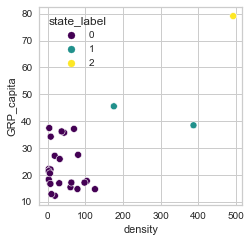

In [9]:
cluststate = states.copy()
scaler = preprocessing.MinMaxScaler().fit(cluststate)
cluststate_std = scaler.transform(cluststate)
cluststate_std = pd.DataFrame(data=cluststate_std, columns=cluststate.columns)

fig = plt.figure(figsize=(8, 8))

clusters = cluster.AgglomerativeClustering(n_clusters=3).fit(cluststate_std)

# Visualization
states["state_label"] = clusters.labels_

ax = fig.add_subplot(2,2,1)
sns.scatterplot(data=states, x="density", y="GRP_capita", hue="state_label", palette="viridis")
plt.show()

In [11]:
customers_data = (pd.merge(customers_data, states.reset_index(), left_on="customer_state", right_on="Code")
                    .drop(columns=['customer_city','customer_zip_code_prefix',
                                   'customer_state','Code', 'density', 'GRP_capita'])
                    .rename(columns={"Flag and name":"state"})
                   )

In [12]:
customers_data.head()

,customer_id,customer_unique_id,state,state_label
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,São Paulo,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,São Paulo,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,São Paulo,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,São Paulo,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,São Paulo,1


<AxesSubplot:xlabel='count', ylabel='state'>

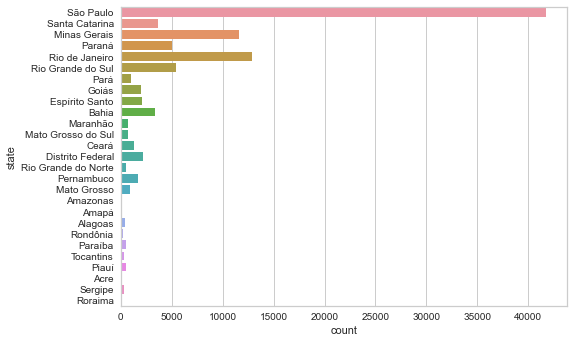

In [13]:
sns.countplot(data=customers_data, y="state", orient="h")

What is the distribution of customers among the clusters?

<AxesSubplot:xlabel='count', ylabel='state_label'>

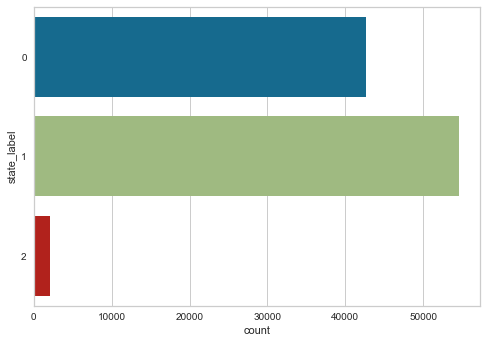

In [205]:
sns.countplot(data=customers_data, y="state_label")

Nearly half of the customers are from Sao Paulo or Rio de Janeiro states! This variable might not be that relevant after all.

# III Reviews dataset

In [30]:
reviews_data = pd.read_csv('./data/olist_order_reviews_dataset.csv', 
                           parse_dates=['review_creation_date', 'review_answer_timestamp'])

reviews_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


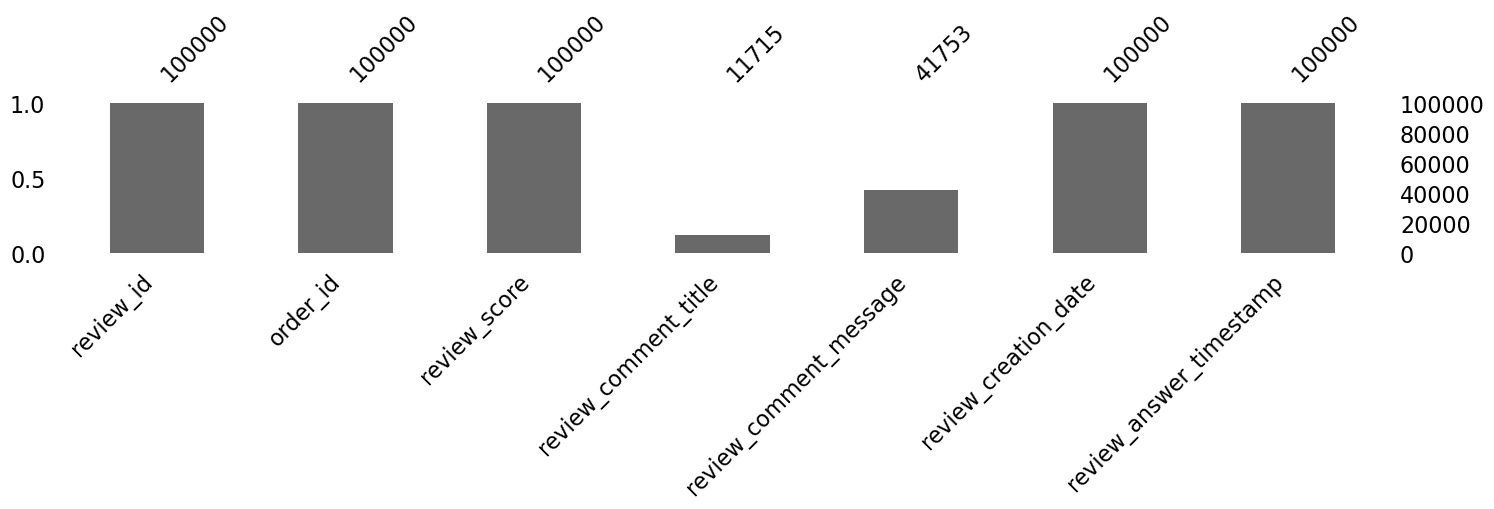

In [35]:
msno.bar(reviews_data, figsize=(15, 5))
plt.gcf().subplots_adjust(bottom=0.5, top=0.8, left=.05, right=.93)
plt.savefig("./images/reviews_msno.png", dpi=300)

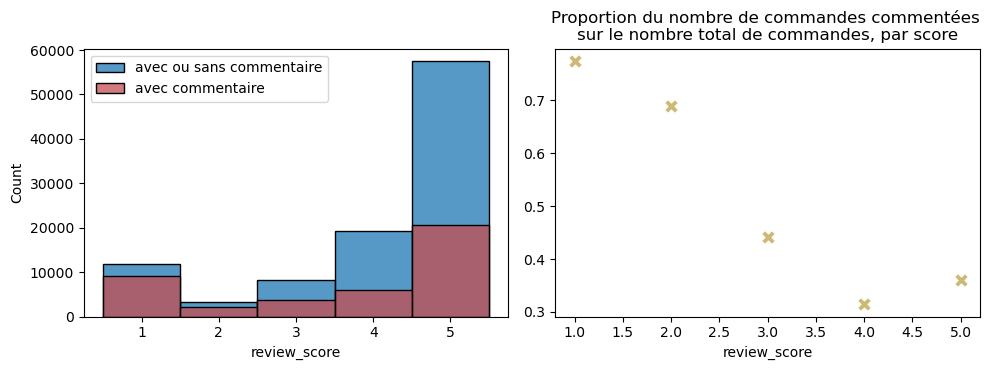

In [38]:
from matplotlib import ticker

sns.reset_defaults()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3.8))

# On affiche la distribution générale des scores
sns.histplot(data=reviews_data, x="review_score", discrete=True, label="avec ou sans commentaire", ax=ax1)
ax1.xaxis.set_major_locator(ticker.FixedLocator(range(7)))

# On affiche maintenant la distribution des scores uniquement lorsqu'un commentaire a été déposé.
df = reviews_data.loc[reviews_data.review_comment_message.notna()]
sns.histplot(data=df, x="review_score", discrete=True, color='r', label="avec commentaire", ax=ax1)
ax1.legend()
ax1.set_title("")

# On affiche le ratio entre le nombre de scores laissés avec commentaire et le nombre de scores laissés 
# avec commentaire - pour chaque score {1, 2, 3, 4, 5}
# Nombre d'individus de score donné
d = reviews_data.groupby("review_score").size()

# Nombre d'individus de score donné, lorsqu'un commentaire a été déposé
e = df.groupby("review_score").size()
f = e/d

sns.scatterplot(data=f, marker='X', s=100, color='y', ax=ax2)
ax2.set_title("Proportion du nombre de commandes commentées \nsur le nombre total de commandes, par score")

plt.tight_layout()
plt.show()

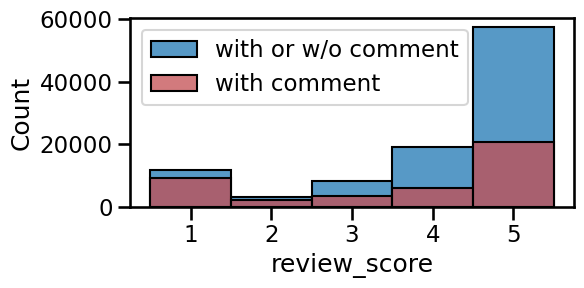

In [187]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(6, 3))

# On affiche la distribution générale des scores
sns.histplot(data=reviews_data, x="review_score", discrete=True, label="with or w/o comment", ax=ax)
ax.xaxis.set_major_locator(ticker.FixedLocator(range(7)))

# On affiche maintenant la distribution des scores uniquement lorsqu'un commentaire a été déposé.
df = reviews_data.loc[reviews_data.review_comment_message.notna()]
sns.histplot(data=df, x="review_score", discrete=True, color='r', label="with comment", ax=ax)
ax.legend(loc="upper left")
ax.set_title("")

plt.gcf().subplots_adjust(bottom=0.25, 
                          left=.25, 
                          right=0.99
                         )
plt.savefig("./images/reviews_comment.png", dpi=300)

Let us calculate and plot the elapsed time between the request for comment and the customer's response, in days

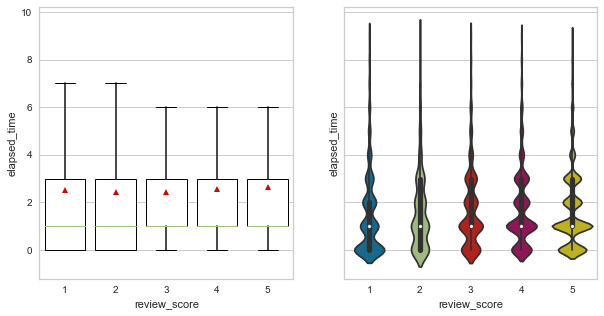

In [208]:
# elapsed time between comment request and response, in days
reviews_data['elapsed_time'] = reviews_data["review_answer_timestamp"] - reviews_data["review_creation_date"]
reviews_data.elapsed_time = reviews_data.elapsed_time.dt.days
reviews_data.drop(columns=["review_creation_date","review_answer_timestamp"], inplace=True)

boxprops, capprops, medianprops = mpl_defaultstyle()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5), sharey=True)
sns.boxplot(data=reviews_data, 
            y="elapsed_time", 
            x="review_score",
            showfliers=False,
            showmeans=True,
            boxprops=boxprops, capprops=capprops, medianprops=medianprops,
            ax=ax1
           )

sns.violinplot(data=reviews_data.query("elapsed_time < 10"), 
               y="elapsed_time", 
               x="review_score", 
               ax=ax2
              )
plt.show()

<AxesSubplot:xlabel='elapsed_time', ylabel='Count'>

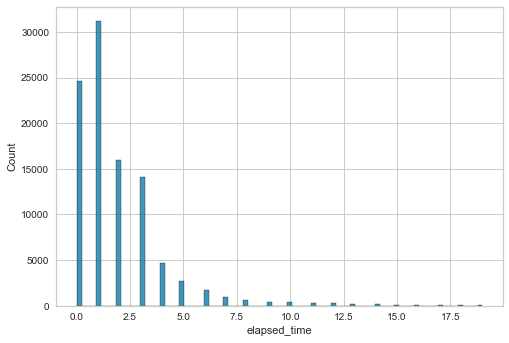

In [209]:
sns.histplot(data=reviews_data.query("elapsed_time < 20"), 
             x="elapsed_time", 
             bins=round(5*np.log2(reviews_data.shape[0]))
            )

We replace the missing values in _review_comment_message_ variable with the value "no_comment", and when the value isn't missing we simple replace it with "comment". Finally, we drop _review_comment_title_

In [210]:
reviews_data.review_comment_message = \
np.where(reviews_data.review_comment_message.isna(),"no_comment", "comment")

reviews_data.drop(columns=["review_comment_title"], inplace=True)

reviews_data.head()

,review_id,order_id,review_score,review_comment_message,elapsed_time
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no_comment,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no_comment,1
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no_comment,1
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,comment,0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,comment,1


# IV Orders dataset

In [52]:
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


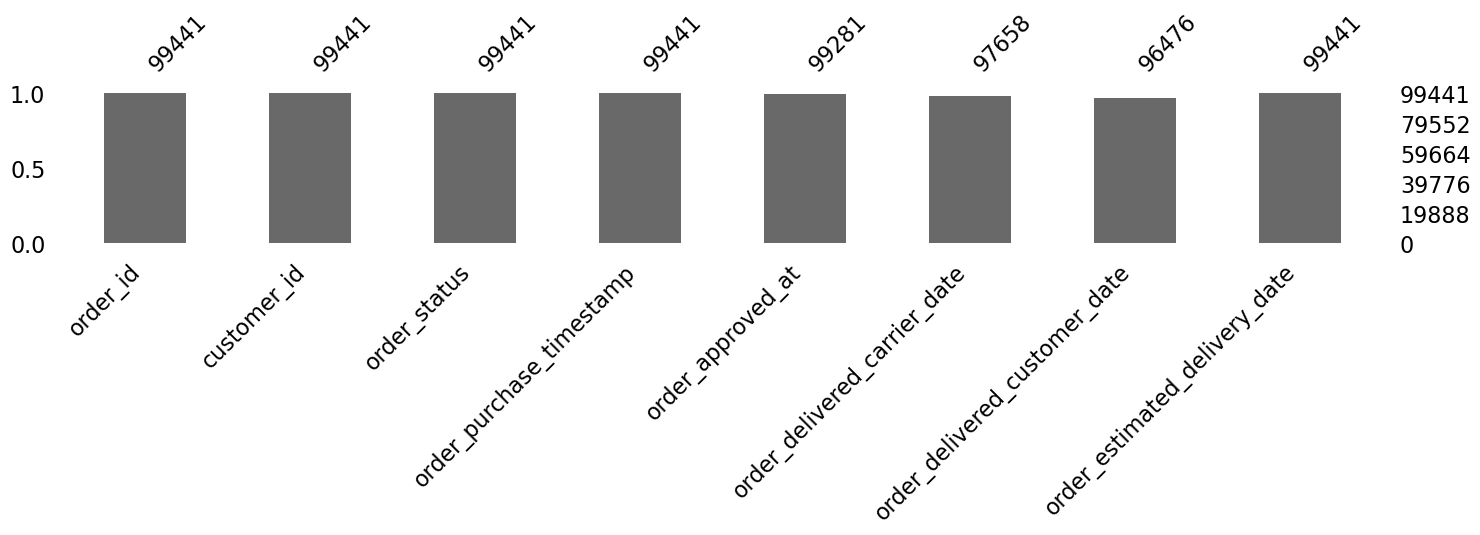

In [56]:
msno.bar(orders_data, figsize=(15, 5))
plt.gcf().subplots_adjust(bottom=0.5, top=0.8, left=.05, right=.93)
plt.savefig("./images/orders_data_msno.png", dpi=300)

What are the possible values for order_status?

In [213]:
orders_data.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

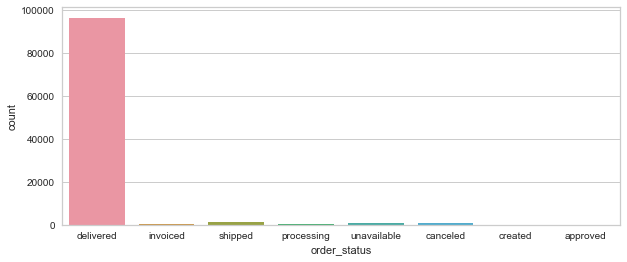

In [214]:
plt.figure(figsize=(10, 4))
sns.countplot(data=orders_data, x='order_status')
plt.show()

We'll only look at the "delivered" orders

In [215]:
orders_data = orders_data[orders_data.order_status=="delivered"]
orders_data.drop(columns="order_status", inplace=True)

<AxesSubplot:>

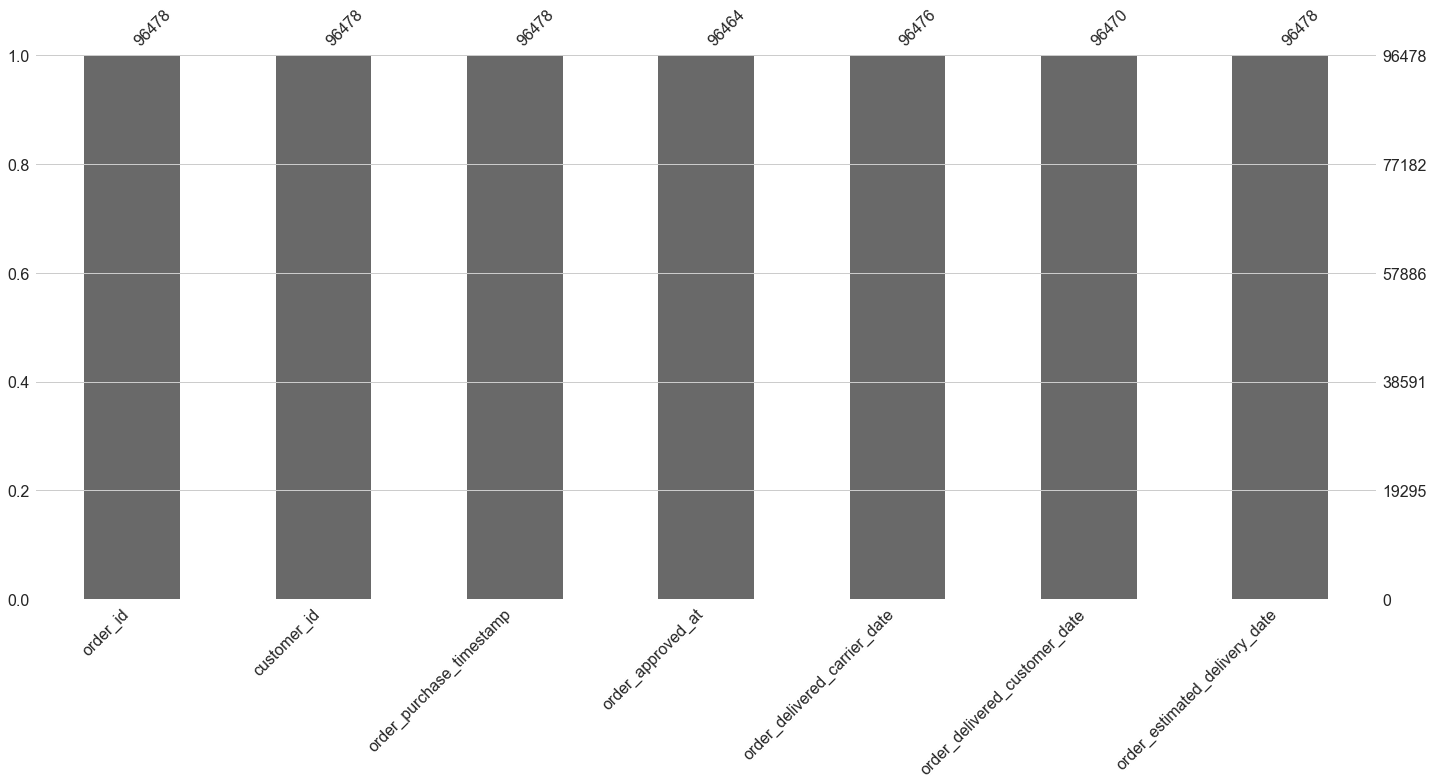

In [216]:
msno.bar(orders_data)

Some items have no order_delivered_customer_date. Let us investigate this.

In [57]:
orders_data[orders_data.order_delivered_customer_date.isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


There is nothing special about them, they seem to be perfectly legitimate orders. But there are only a few, tehrefore we choose to drop them.

In [58]:
no_delivery_stamp = orders_data[orders_data.order_delivered_customer_date.isna()].index
orders_data = orders_data.drop(index=no_delivery_stamp)

We'll also drop the columns "order_approved_at", "order_delivered_carrier_date", "order_estimated_delivery_date"

In [59]:
orders_data.drop(columns=["order_approved_at",
                          "order_delivered_carrier_date",
                          "order_estimated_delivery_date"], inplace=True)

<AxesSubplot:>

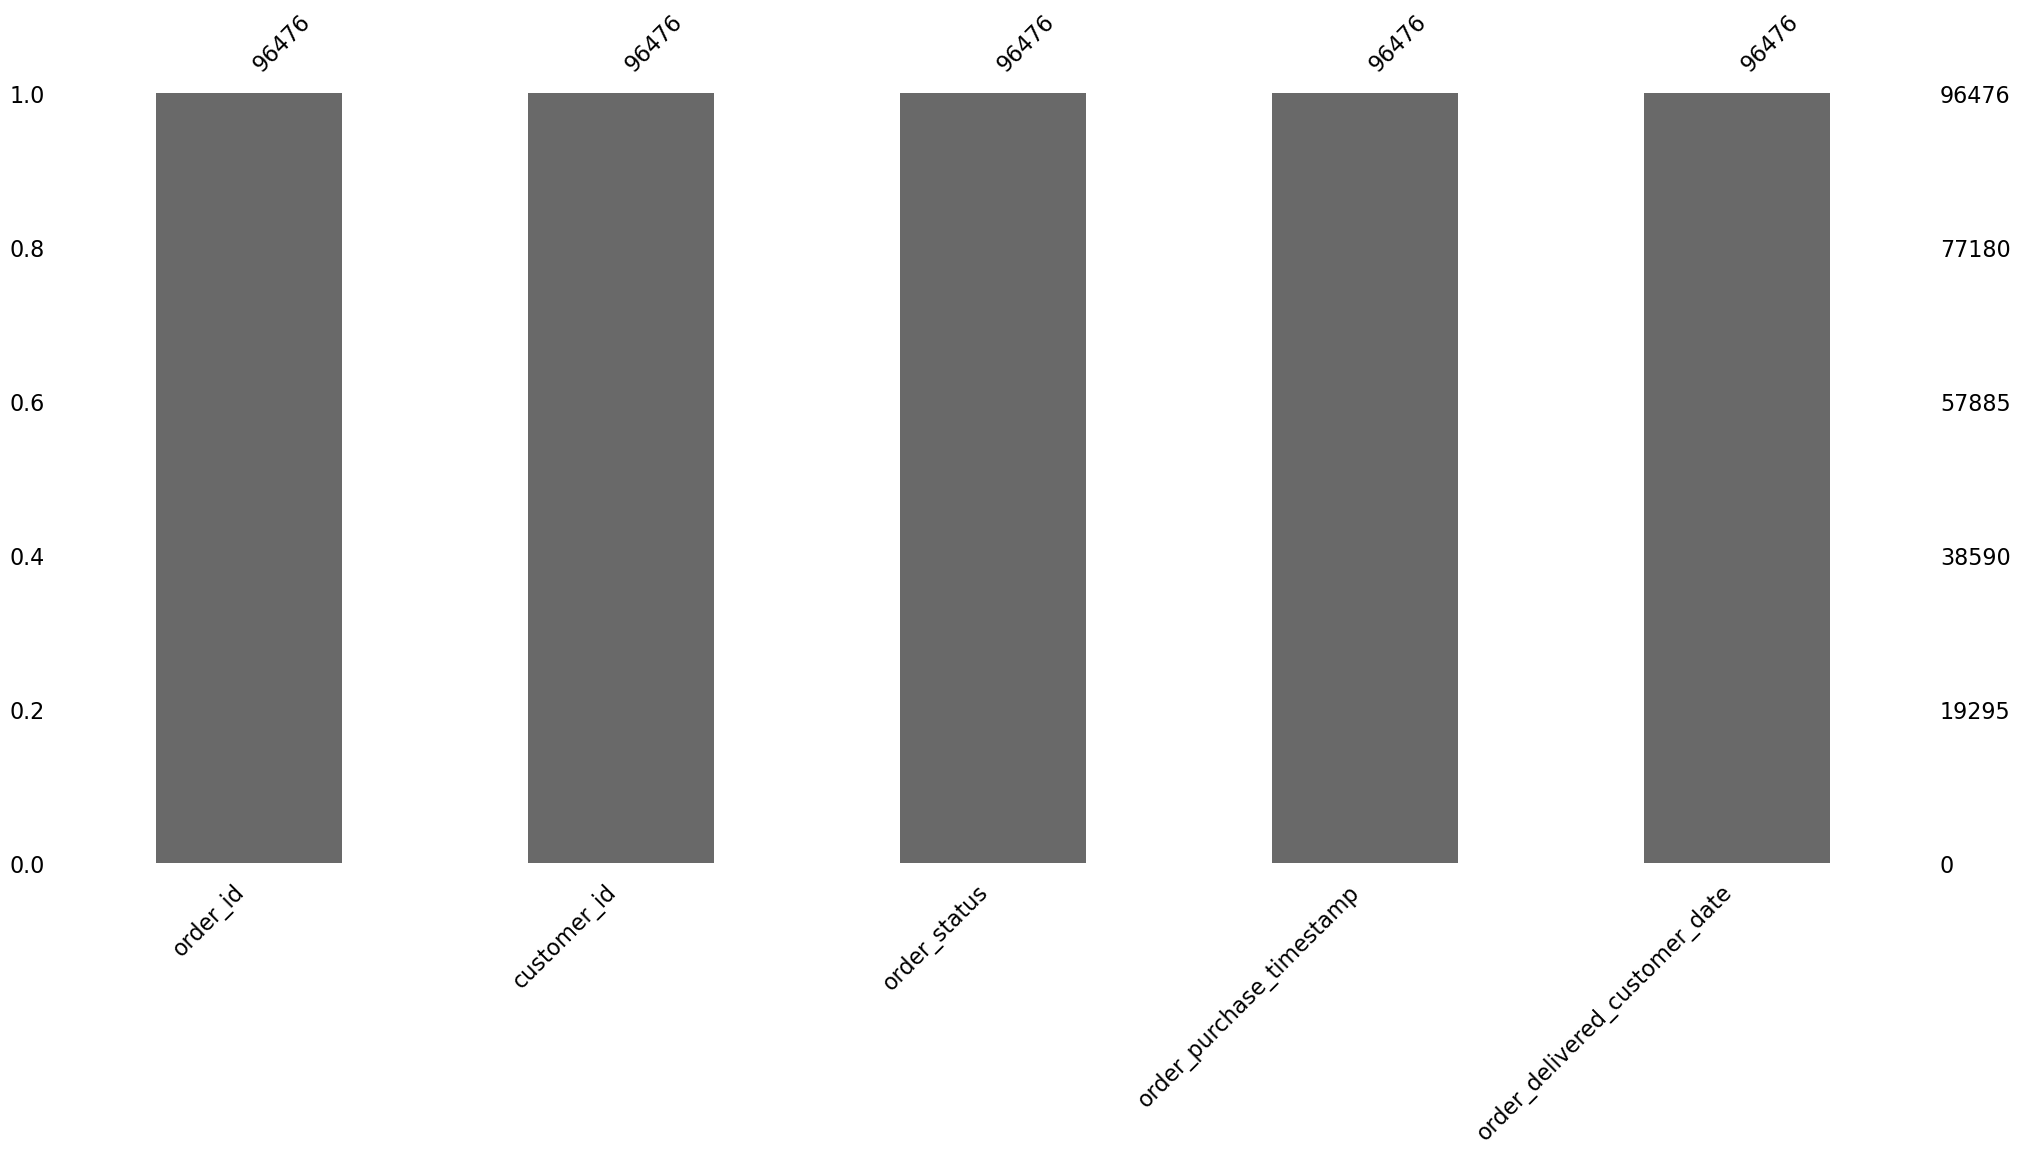

In [60]:
msno.bar(orders_data)

Mean elapsed time between purchase and reception?

In [66]:
sns.set_context("talk")

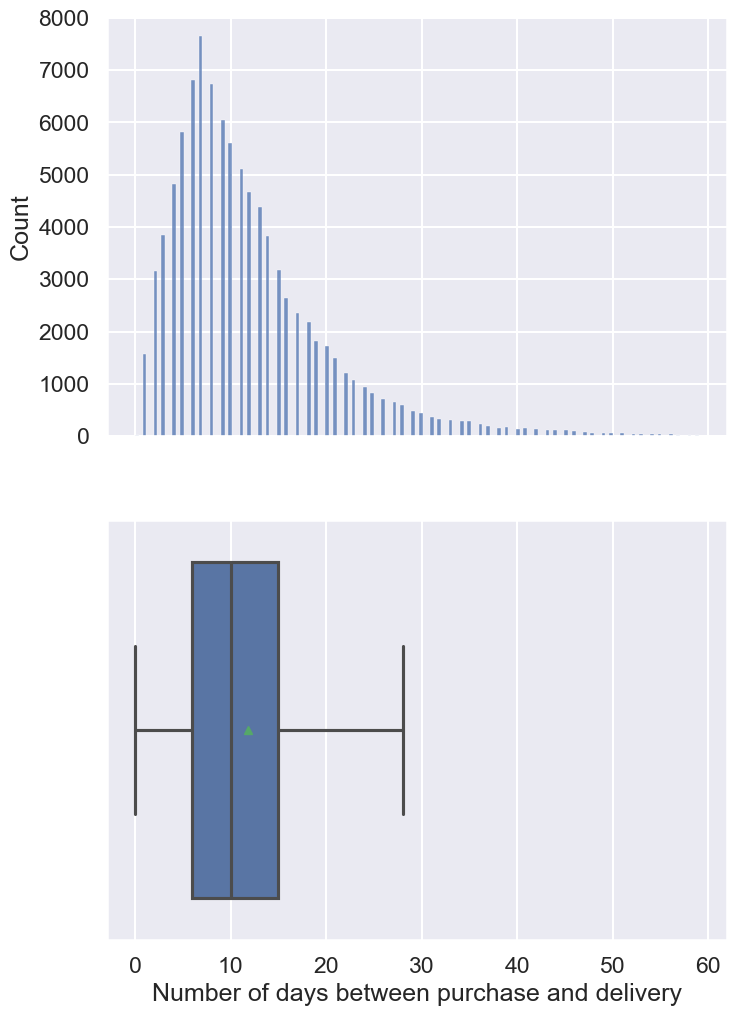

In [71]:
orders_data['purchase_to_delivery_time'] = (orders_data['order_delivered_customer_date'] - 
                                            orders_data['order_purchase_timestamp']).dt.days

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 12))
sns.histplot(data=orders_data.query('purchase_to_delivery_time < 60'), x='purchase_to_delivery_time', ax=ax1)
sns.boxplot(data=orders_data.query('purchase_to_delivery_time < 60'), x='purchase_to_delivery_time', showfliers=False, showmeans=True, ax=ax2)
plt.xlabel("Number of days between purchase and delivery")
#plt.gcf().subplots_adjust(bottom=0.5, left=.2)
plt.savefig("./images/orders_data.png", dpi=300)
plt.show()

Now we can get rid of the "order_delivered_customer_date" column

In [72]:
orders_data.drop(columns="order_delivered_customer_date", inplace=True)
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,purchase_to_delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2


In [73]:
orders_data["order_purchase_timestamp"] = orders_data["order_purchase_timestamp"].dt.date
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,purchase_to_delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2


# V Order Items dataset

In [74]:
items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [82]:
sns.reset_defaults()

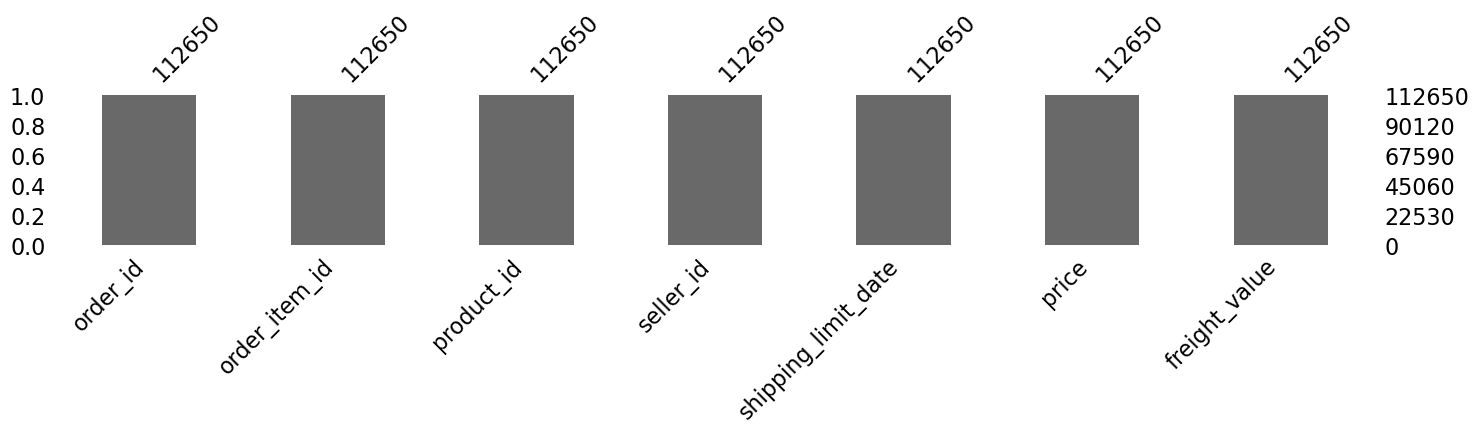

In [84]:
msno.bar(items_data, figsize=(15, 5))
plt.gcf().subplots_adjust(bottom=0.5, top=0.8, left=.05, right=.93)
plt.savefig("./images/items_data_msno.png", dpi=300)

Let us calculate the total value for each item

In [ ]:
items_data["total_order_value"] = items_data.price + items_data.freight_value

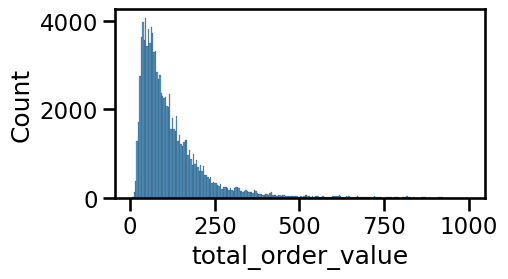

In [189]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(data=items_data.query('total_order_value < 1000'), x="total_order_value")
plt.gcf().subplots_adjust(bottom=0.25, left=.25, right=.99)
plt.savefig("./images/items_data_tov.png", dpi=300)

# VI Payments dataset

In [227]:
payments_data.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [158]:
sns.reset_defaults()

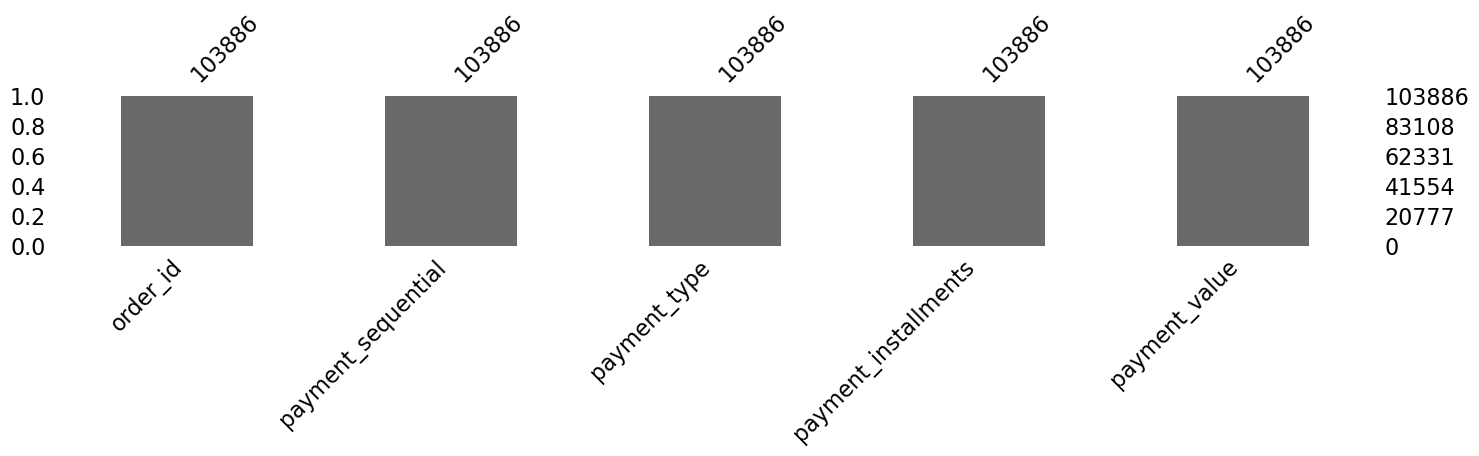

In [160]:
msno.bar(payments_data, figsize=(15, 5))
plt.gcf().subplots_adjust(bottom=0.5, top=0.8, left=.05, right=.93)
plt.savefig("./images/payments_data_msno.png", dpi=300)

Each row is completely referenced by "order_id" and "payment_sequential". 

In [228]:
payments_data.groupby(["order_id", "payment_sequential"]).size().unique()

array([1])

This means that some orders have multiple "payment_sequential" fields. Let us look at one of them, the one with the highest value of "payment_sequential"

In [229]:
multiple_sequence_order = payments_data.loc[payments_data.payment_sequential==29, "order_id"]
payments_data[payments_data.order_id.isin(multiple_sequence_order)]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
24879,fa65dad1b0e818e3ccc5cb0e39231352,25,voucher,1,3.68
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
32519,fa65dad1b0e818e3ccc5cb0e39231352,11,voucher,1,4.03


It seems that the correct thing to do here is to:
- count the number of rows associated with a specific order. This will give us the number of payment_sequential.
- get the value (for a given payment method) of payment installments
- sum the payment_value in order to get the total value for the order.

In [230]:
nb_sequence = (payments_data.groupby(["order_id", "payment_type"])
               .agg({"payment_sequential":"count","payment_value":"sum"})
               .reset_index("payment_type")
              )

payments_data = pd.merge(payments_data[["order_id", "payment_installments"]], nb_sequence, on="order_id", right_index=True)

The rows associated to one specific order_id and that used to  have a different number of "payment_sequential" are now duplicates:

In [231]:
payments_data[payments_data.order_id.isin(multiple_sequence_order)]

,order_id,payment_installments,payment_type,payment_sequential,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
9985,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
17274,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
19565,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
23074,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
24879,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
28330,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
29648,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99
32519,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,29,457.99


We just need to drop_duplicates on these rows:

In [232]:
payments_data.drop_duplicates(inplace=True)
payments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103274 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103274 non-null  object 
 1   payment_installments  103274 non-null  int64  
 2   payment_type          103274 non-null  object 
 3   payment_sequential    103274 non-null  int64  
 4   payment_value         103274 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.7+ MB


In [233]:
payments_data.head()

,order_id,payment_installments,payment_type,payment_sequential,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,8,credit_card,1,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,8,credit_card,1,107.78
4,42fdf880ba16b47b59251dd489d4441a,2,credit_card,1,128.45


<AxesSubplot:xlabel='payment_type', ylabel='count'>

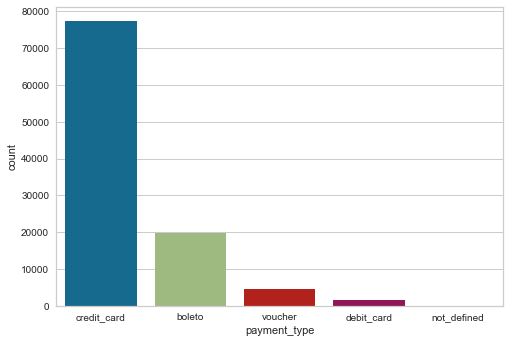

In [234]:
sns.countplot(data=payments_data, x="payment_type")

The vast majority of payments are made with credit card... this variable alone might not be useful. We will also get rid of the customers for whom the payment_type is "not_defined"

In [235]:
not_defined = payments_data[payments_data.payment_type=="not_defined"].index
payments_data.drop(index=not_defined, inplace=True)

<AxesSubplot:xlabel='payment_type', ylabel='payment_value'>

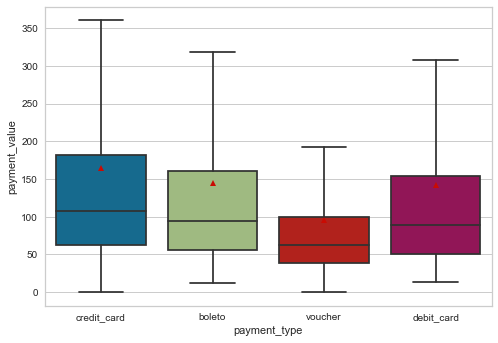

In [236]:
sns.boxplot(data=payments_data, 
            x="payment_type",
            y="payment_value",
            showfliers=False,
            showmeans=True
           )

We can create another variable, informing on whether a customer makes high, mid or low value purchases given the type of payment.

We will first calculate the ratio between payment_value and payment_installments: this way we will be able to tell between customers who paid for high value purchases in full, and those who split their purchases in several installments.\
Let us start by looking at the distribution of installments

In [237]:
payments_data.payment_installments.describe()

count    103271.000000
mean          2.886512
std           2.701426
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

Some orders have 0 installments.

In [238]:
payments_data[payments_data.payment_installments==0]

,order_id,payment_installments,payment_type,payment_sequential,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,0,credit_card,1,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,0,credit_card,1,129.94


 This is clearly an error and since there are only a couple of them, we choose to drop them

In [239]:
installments_outliers = payments_data[payments_data.payment_installments==0].index
payments_data.drop(index=installments_outliers, inplace=True)

payments_data["mean_value_per_installment"] = round(payments_data["payment_value"]/payments_data["payment_installments"], 2)
payments_data.head()

,order_id,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment
0,b81ef226f3fe1789b1e8b2acac839d17,8,credit_card,1,99.33,12.42
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,65.71
3,ba78997921bbcdc1373bb41e913ab953,8,credit_card,1,107.78,13.47
4,42fdf880ba16b47b59251dd489d4441a,2,credit_card,1,128.45,64.22


In [240]:
payments_data["mean_value_per_installment"] = round(payments_data["payment_value"]/payments_data["payment_installments"], 2)
payments_data.head()

,order_id,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment
0,b81ef226f3fe1789b1e8b2acac839d17,8,credit_card,1,99.33,12.42
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,65.71
3,ba78997921bbcdc1373bb41e913ab953,8,credit_card,1,107.78,13.47
4,42fdf880ba16b47b59251dd489d4441a,2,credit_card,1,128.45,64.22


In [241]:
value_for_type = (payments_data.groupby("payment_type")["mean_value_per_installment"]
                  .apply(lambda x: (x - x.mean())/x.std())
                  .rename("value_for_type")
                 )

payments_data = pd.concat([payments_data, value_for_type], axis=1)
payments_data.head()

,order_id,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment,value_for_type
0,b81ef226f3fe1789b1e8b2acac839d17,8,credit_card,1,99.33,12.42,-0.514921
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,24.39,-0.394778
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,65.71,0.019948
3,ba78997921bbcdc1373bb41e913ab953,8,credit_card,1,107.78,13.47,-0.504382
4,42fdf880ba16b47b59251dd489d4441a,2,credit_card,1,128.45,64.22,0.004993


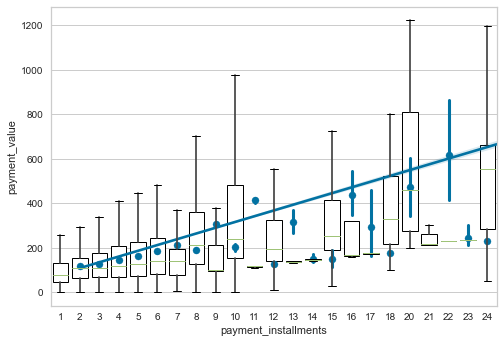

In [242]:
# Affichage de la relation nb d'acomptes vs prix de la commande
boxprops, capprops, medianprops = mpl_defaultstyle()
sns.regplot(data=payments_data, x="payment_installments", y="payment_value", x_estimator=np.mean)
sns.boxplot(data=payments_data, 
            x="payment_installments",
            y="payment_value",
            showfliers=False,
            medianprops=medianprops,
            capprops=capprops,
            boxprops=boxprops)
plt.show()

# VII Creation of the final dataset - Towards RFM segmentation
We start investigating how the data at hand will allow us to perform rfm segmentation. 
First, we need to merge the various tables we have explored so far.\
We start by merging "orders_data" with "customer_data" on the customer_id key.

In [243]:
data = (pd.merge(orders_data, customers_data, on="customer_id")
        .drop(columns=["customer_id"])
       )
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,13,af07308b275d755c9edb36a90c618231,Bahia,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08,9,3a653a41f6f9fc3d2a113cf8398680e8,Goiás,0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18,13,7c142cf63193a1473d2e66489a9ae977,Rio Grande do Norte,0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6,São Paulo,1


In [244]:
data = (pd.merge(data, items_data, on="order_id")
        .drop(columns=["seller_id", "shipping_limit_date", "order_item_id"])
        .drop_duplicates()
       )
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,product_id,price,freight_value,total_order_value
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,87285b34884572647811a353c7ac498a,29.99,8.72,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,13,af07308b275d755c9edb36a90c618231,Bahia,0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08,9,3a653a41f6f9fc3d2a113cf8398680e8,Goiás,0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18,13,7c142cf63193a1473d2e66489a9ae977,Rio Grande do Norte,0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6,São Paulo,1,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,28.62


Merging with the products dataset on "product_id"

In [245]:
data = (pd.merge(data, products_data_english, on="product_id")
        .drop(columns="product_id")
        .drop_duplicates()
       )
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,price,freight_value,total_order_value,product_category
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools
1,128e10d95713541c87cd1a2e48201934,2017-08-15,2,3a51803cc0d012c3b5dc8b7528cb05f7,São Paulo,1,29.99,7.78,37.77,home_garden_tools
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,5,ef0996a1a279c26e7ecbd737be23d235,São Paulo,1,29.99,7.78,37.77,home_garden_tools
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,14,e781fdcc107d13d865fc7698711cc572,Santa Catarina,0,29.99,14.10,44.09,home_garden_tools
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,13,af07308b275d755c9edb36a90c618231,Bahia,0,118.70,22.76,141.46,health_beauty_baby


2. Reviews

In [246]:
data = pd.merge(data, reviews_data, on="order_id")
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,price,freight_value,total_order_value,product_category,review_id,review_score,review_comment_message,elapsed_time
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,4,comment,1
1,128e10d95713541c87cd1a2e48201934,2017-08-15,2,3a51803cc0d012c3b5dc8b7528cb05f7,São Paulo,1,29.99,7.78,37.77,home_garden_tools,b46f1e34512b0f4c74a72398b03ca788,4,comment,1
2,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,5,ef0996a1a279c26e7ecbd737be23d235,São Paulo,1,29.99,7.78,37.77,home_garden_tools,dc90f19c2806f1abba9e72ad3c350073,5,comment,0
3,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,14,e781fdcc107d13d865fc7698711cc572,Santa Catarina,0,29.99,14.10,44.09,home_garden_tools,1bafb430e498b939f258b9c9dbdff9b1,3,no_comment,2
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,13,af07308b275d755c9edb36a90c618231,Bahia,0,118.70,22.76,141.46,health_beauty_baby,8d5266042046a06655c8db133d120ba5,4,comment,0


3. payments_data

In [247]:
data = pd.merge(data, payments_data, on="order_id")
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,price,freight_value,total_order_value,product_category,review_id,review_score,review_comment_message,elapsed_time,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment,value_for_type
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,4,comment,1,1,credit_card,1,18.12,18.12,-0.457710
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,4,comment,1,1,voucher,2,20.59,20.59,-0.487560
2,128e10d95713541c87cd1a2e48201934,2017-08-15,2,3a51803cc0d012c3b5dc8b7528cb05f7,São Paulo,1,29.99,7.78,37.77,home_garden_tools,b46f1e34512b0f4c74a72398b03ca788,4,comment,1,3,credit_card,1,37.77,12.59,-0.513214
3,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,5,ef0996a1a279c26e7ecbd737be23d235,São Paulo,1,29.99,7.78,37.77,home_garden_tools,dc90f19c2806f1abba9e72ad3c350073,5,comment,0,1,credit_card,1,37.77,37.77,-0.260484
4,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,14,e781fdcc107d13d865fc7698711cc572,Santa Catarina,0,29.99,14.10,44.09,home_garden_tools,1bafb430e498b939f258b9c9dbdff9b1,3,no_comment,2,1,boleto,1,44.09,44.09,-0.472628


This dataframe contains all information we will need to finalize the feature engineering and later perform the clustering. Because we also have in mind that we will have to create multiple "sub dataframes" to evaluate the stability of the clustering over time, we save this dataframes to a csv file in order to reuse it later.

In [248]:
data.to_csv('./data/raw_data.csv', index_label=False)

Now, what we need is a dataset referenced by the customers (customer_unique_id), where the columns characterize different aspects of the customers. For instance, we wiil look for:
- recency: date of last purchase
- frequency: how many orders a client has placed on Olist?
- monetary value (of last purchase or average over a period of time)

and other characteristics which are also represented in the table.

Here the recency is calculated relative to the most recent timestamp found in the dataset as a first exploration.

In [170]:
time_parser = dict(order_purchase_timestamp="datetime64[ns]")
data = pd.read_csv('./data/raw_data.csv').astype(time_parser)
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,price,freight_value,total_order_value,product_category,review_id,review_score,review_comment_message,elapsed_time,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment,value_for_type
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,4,comment,1,1,credit_card,1,18.12,18.12,-0.457710
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,38.71,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,4,comment,1,1,voucher,2,20.59,20.59,-0.487560
2,128e10d95713541c87cd1a2e48201934,2017-08-15,2,3a51803cc0d012c3b5dc8b7528cb05f7,São Paulo,1,29.99,7.78,37.77,home_garden_tools,b46f1e34512b0f4c74a72398b03ca788,4,comment,1,3,credit_card,1,37.77,12.59,-0.513214
3,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,5,ef0996a1a279c26e7ecbd737be23d235,São Paulo,1,29.99,7.78,37.77,home_garden_tools,dc90f19c2806f1abba9e72ad3c350073,5,comment,0,1,credit_card,1,37.77,37.77,-0.260484
4,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,14,e781fdcc107d13d865fc7698711cc572,Santa Catarina,0,29.99,14.10,44.09,home_garden_tools,1bafb430e498b939f258b9c9dbdff9b1,3,no_comment,2,1,boleto,1,44.09,44.09,-0.472628


In [171]:
# purchase recency
latest_timestamp = data.order_purchase_timestamp.max()
data.loc[:, 'purchase_recency'] = (latest_timestamp - data.order_purchase_timestamp).dt.days

Concerning the monetary value, we need a value that is both as little correlated with frequency as possible, while being meaningful. The average monetary value (over all items within each order placed by every single customer) is not really meaningful, since two customers might end up with the same value even though one buys many "small" items in one order while the other only buys one item. On the other hand, the total monetary value (as the sum over _every_ items) will be correlated with the frequency of purchase, since the higher the frequency, the more items are bought. Therefore we settle with the average monetary value _per order_. This way, a customer placing a single order for a high value distributed over many small items will still represent a "high value" customer, and for a given total monetary value, the value per order will be lowered as the number of orders goes up, making the frequency variable not as obviously correlated with high monetary value as it would have been in the case the monetary value represented the total amount paid by a customer.

In [172]:
# monetary value. We'll calculate the average monetary value per order 
# to avoid correlation with the frequency variable while retaining some meaningfulness
monetary_value_per_order = (data.groupby(["order_id"])
                  .agg(monetary_value=pd.NamedAgg(column="total_order_value", aggfunc="sum"))
                 )

data = pd.merge(data.drop(columns="total_order_value"), monetary_value_per_order, on="order_id")

In [173]:
data.head()

,order_id,order_purchase_timestamp,purchase_to_delivery_time,customer_unique_id,state,state_label,price,freight_value,product_category,review_id,...,review_comment_message,elapsed_time,payment_installments,payment_type,payment_sequential,payment_value,mean_value_per_installment,value_for_type,purchase_recency,monetary_value
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,...,comment,1,1,credit_card,1,18.12,18.12,-0.457710,331,77.42
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,8,7c396fd4830fd04220f754e42b4e5bff,São Paulo,1,29.99,8.72,home_garden_tools,a54f0611adc9ed256b57ede6b6eb5114,...,comment,1,1,voucher,2,20.59,20.59,-0.487560,331,77.42
2,128e10d95713541c87cd1a2e48201934,2017-08-15,2,3a51803cc0d012c3b5dc8b7528cb05f7,São Paulo,1,29.99,7.78,home_garden_tools,b46f1e34512b0f4c74a72398b03ca788,...,comment,1,3,credit_card,1,37.77,12.59,-0.513214,379,37.77
3,0e7e841ddf8f8f2de2bad69267ecfbcf,2017-08-02,5,ef0996a1a279c26e7ecbd737be23d235,São Paulo,1,29.99,7.78,home_garden_tools,dc90f19c2806f1abba9e72ad3c350073,...,comment,0,1,credit_card,1,37.77,37.77,-0.260484,392,37.77
4,bfc39df4f36c3693ff3b63fcbea9e90a,2017-10-23,14,e781fdcc107d13d865fc7698711cc572,Santa Catarina,0,29.99,14.10,home_garden_tools,1bafb430e498b939f258b9c9dbdff9b1,...,no_comment,2,1,boleto,1,44.09,44.09,-0.472628,310,44.09


In [174]:
# product_categories
product_categories = (data.groupby("customer_unique_id")["product_category"]
                      .pipe(lambda grp: grp.value_counts())
                      .unstack()
                      .fillna(0)
                     )

# reviews
review_comment_message = (data.groupby("customer_unique_id")["review_comment_message"]
                          .pipe(lambda grp: grp.value_counts())
                          .unstack()
                          .fillna(0)
                         )
# payment types
payment_types = (data.groupby("customer_unique_id")["payment_type"]
                          .pipe(lambda grp: grp.value_counts())
                          .unstack()
                          .fillna(0)
                         )

# state_label
state_labels = (data.groupby("customer_unique_id")["state_label"]
                          .pipe(lambda grp: grp.value_counts())
                          .unstack()
                          .fillna(0)
                         )

In [175]:
# create variables
data = (data.groupby("customer_unique_id")
     .agg({"order_id":"count",
           "purchase_recency":"min",
           "monetary_value":"mean",
           "purchase_to_delivery_time":"mean",
           "review_score":"mean",
           "elapsed_time":"mean",
           "payment_installments":"mean",
           "payment_sequential":"mean",
           "value_for_type":"mean"
          })
     .rename(columns={"order_id":"frequency",
                      "purchase_to_delivery":"mean_purchase_to_delivery",
                      "review_score":"mean_review_score",
                      "elapsed_time":"mean_comment_elapsed_time",
                      "payment_installments":"mean_nb_installments",
                      "payment_sequential":"mean_nb_payment_types",
                      "value_for_type":"mean_value_for_type"
                     }
                  )
 
)

data.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,mean_nb_payment_types,mean_value_for_type
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90,6.0,5.0,4.0,8.0,1.0,-0.461524
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114,27.19,3.0,4.0,0.0,1.0,1.0,-0.366675
0000f46a3911fa3c0805444483337064,1,537,86.22,25.0,3.0,1.0,8.0,1.0,-0.531381
0000f6ccb0745a6a4b88665a16c9f078,1,321,43.62,20.0,4.0,1.0,4.0,1.0,-0.530177
0004aac84e0df4da2b147fca70cf8255,1,288,196.89,13.0,5.0,4.0,6.0,1.0,-0.310167


In [176]:
data = pd.merge(data, product_categories, on="customer_unique_id")
data.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,mean_nb_payment_types,mean_value_for_type,accessories,fashion_clothing,food_beverages,health_beauty_baby,home_garden_tools,toys_hobby
customer_unique_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90,6.0,5.0,4.0,8.0,1.0,-0.461524,1.0,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114,27.19,3.0,4.0,0.0,1.0,1.0,-0.366675,0.0,0.0,0.0,1.0,0.0,0.0
0000f46a3911fa3c0805444483337064,1,537,86.22,25.0,3.0,1.0,8.0,1.0,-0.531381,1.0,0.0,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,1,321,43.62,20.0,4.0,1.0,4.0,1.0,-0.530177,1.0,0.0,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,1,288,196.89,13.0,5.0,4.0,6.0,1.0,-0.310167,1.0,0.0,0.0,0.0,0.0,0.0


In [177]:
data = (pd.merge(data, review_comment_message, on="customer_unique_id")
        .rename(columns={"no":"no_comment", "yes":"comment"})
       )

data.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,mean_nb_payment_types,mean_value_for_type,accessories,fashion_clothing,food_beverages,health_beauty_baby,home_garden_tools,toys_hobby,comment,no_comment
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90,6.0,5.0,4.0,8.0,1.0,-0.461524,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114,27.19,3.0,4.0,0.0,1.0,1.0,-0.366675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0000f46a3911fa3c0805444483337064,1,537,86.22,25.0,3.0,1.0,8.0,1.0,-0.531381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0000f6ccb0745a6a4b88665a16c9f078,1,321,43.62,20.0,4.0,1.0,4.0,1.0,-0.530177,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,1,288,196.89,13.0,5.0,4.0,6.0,1.0,-0.310167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# VIII Exploratory Analysis

Let us have a look at the purchase_recency variable.

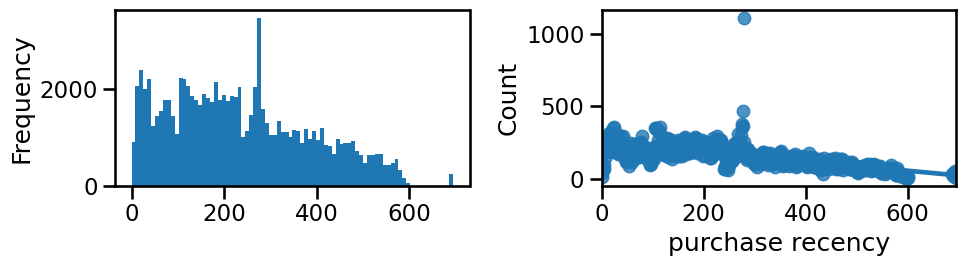

In [178]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
recency = data.loc[:, "purchase_recency"]
recency.plot(kind='hist', bins=round(5*np.log2(data.shape[0])), ax=ax1)

recencies = pd.Series(recency, name="purchase_recency")
nb_orders_per_recency = recencies.value_counts()

g = (pd.DataFrame(data=nb_orders_per_recency)
    .reset_index()
    .rename(columns={"index":"recency", "purchase_recency":"nb_orders"})
    )


sns.regplot(data=g, x="recency", y="nb_orders", ax=ax2)
ax2.set_ylabel("Count")
ax2.set_xlabel("purchase recency")

plt.tight_layout()
plt.show()

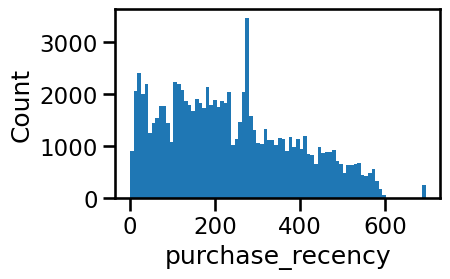

In [180]:
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(5, 3))
recency.plot(kind='hist', bins=round(5*np.log2(data.shape[0])), ax=ax)
ax.set_xlabel("purchase_recency")
ax.set_ylabel("Count")
plt.gcf().subplots_adjust(left=0.25, bottom=0.25)
plt.savefig("./images/purchase_recency.png", dpi=300)
plt.show()

There seem to be a long gap of about 100 days during which no purchase were made. We will only keep the data with recency <= 610 days.

In [190]:
data = data[data.purchase_recency<=610]

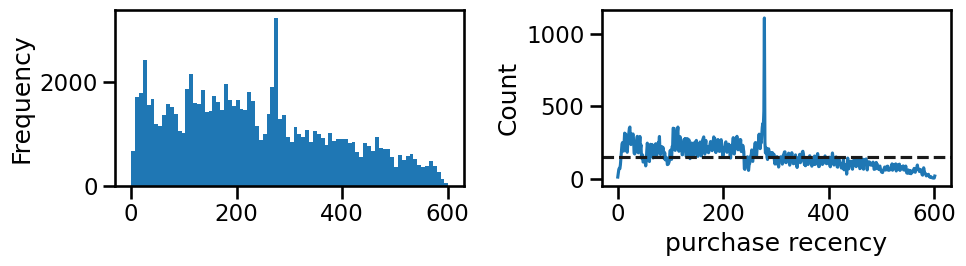

In [191]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
recency = data.loc[:, "purchase_recency"]
recency.plot(kind='hist', bins=round(5*np.log2(data.shape[0])), ax=ax1)

recencies = pd.Series(recency, name="purchase_recency")
nb_orders_per_recency = recencies.value_counts()

g = data.groupby("purchase_recency").size()
g = (pd.DataFrame(data=g)
    .rename(columns={0:"nb_orders"})
    )

sns.lineplot(data=g.reset_index(), x="purchase_recency", y="nb_orders", ax=ax2)
ax2.set_ylabel("Count")
ax2.set_xlabel("purchase recency")
ax2.axhline(y = g.nb_orders.mean(), ls='--', c='k')

plt.tight_layout()
plt.show()

In [192]:
# average number of orders per day
g.nb_orders.mean()

152.51993355481727

Over the entire 600+ days period, there is an average of 153 orders per day.

Most customers have bought only once over the whole timespan. Therefore, most of new orders are made by new customers. Can we bin the purchase recencies in order to get roughly equal number of purchases over each time period? 

In [ ]:
sns.reset_defaults()
sns.set_theme()

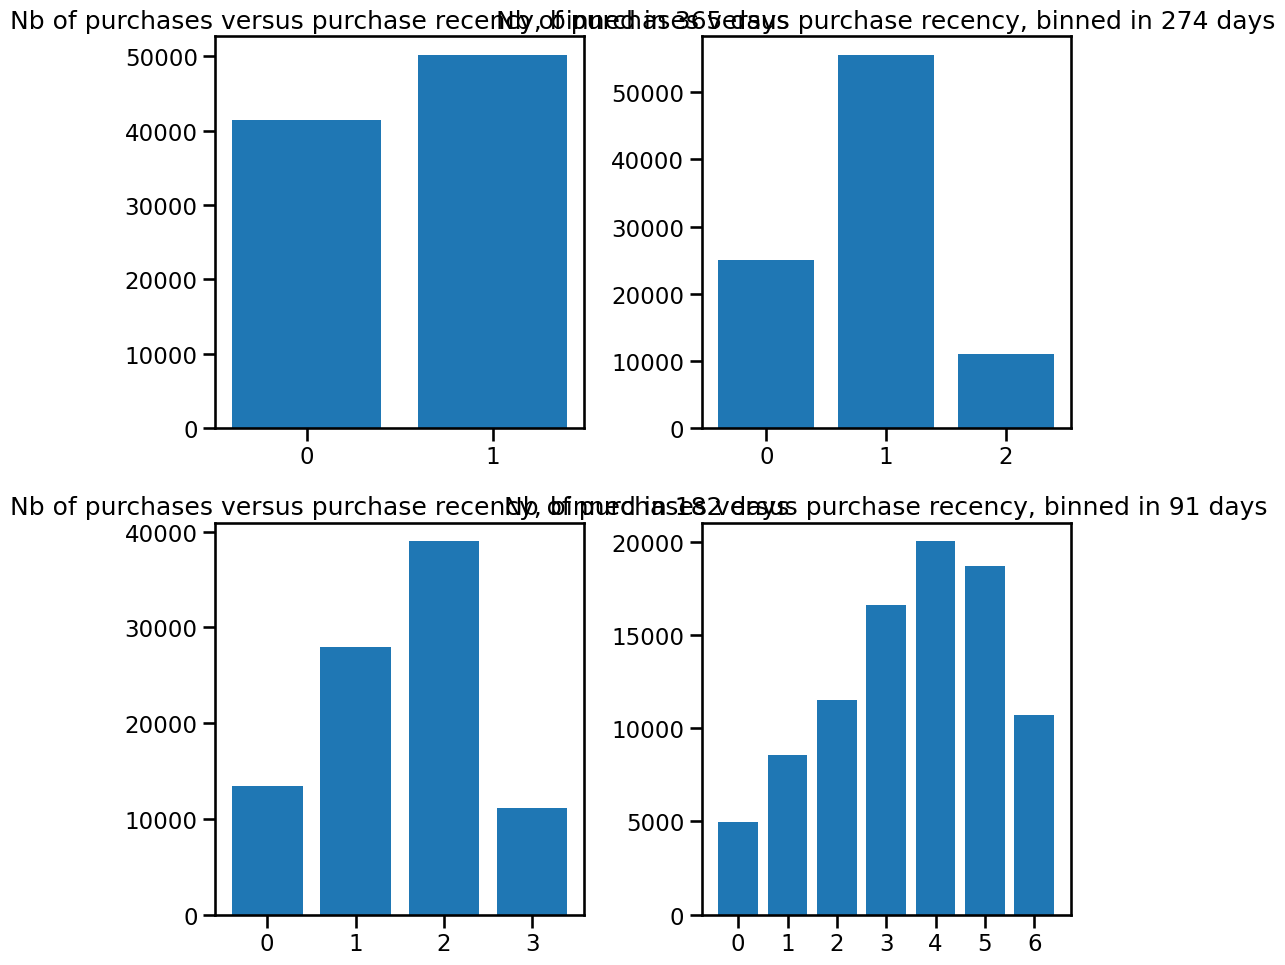

In [193]:
# 1 year period
one_y = 365

# 9 months
nine_m = round(0.75*365)
# 6 months
six_m = round(365/2)

# 3 months
three_m = round(365/4)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for ax, duration in zip([ax1, ax2, ax3, ax4], [one_y, nine_m, six_m, three_m]):
    X = data.copy()
    non_empty = True
    nb_purchases = []
    
    while X.shape[0]>0:
        time_cut_old = X.purchase_recency.max()
        time_cut_recent = X.purchase_recency.max() - duration
        slice_df = X.query('purchase_recency>@time_cut_recent')
        nb_purchases.append(slice_df.shape[0])
        X = X.query('purchase_recency<@time_cut_recent')
    
    x = np.arange(len(nb_purchases))
    y = np.array(nb_purchases)
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_title(f"Nb of purchases versus purchase recency, binned in {duration} days")

plt.tight_layout()
plt.show()

It seems that binning the dataset in order to get an equal number of purchases over each time period isn't possible, however, we see that if we add all purchases made during the first year, we can manage to get two 6-months period with roughly equal number of purchases. This might hint at 6-months periods as the optimal binning of the data.

In [194]:
pd.Series(data.columns)

0                     frequency
1              purchase_recency
2                monetary_value
3     purchase_to_delivery_time
4             mean_review_score
5     mean_comment_elapsed_time
6          mean_nb_installments
7         mean_nb_payment_types
8           mean_value_for_type
9                   accessories
10             fashion_clothing
11               food_beverages
12           health_beauty_baby
13            home_garden_tools
14                   toys_hobby
15                      comment
16                   no_comment
dtype: object

What about the distribution of product categories among unique customers?

In [195]:
category_columns = data.columns[9:15]
df = data.reset_index().copy()

df = df.melt(id_vars="customer_unique_id", 
        value_vars=category_columns,
        var_name="product_category",
        value_name="nb_purchased")

grouped = df.groupby("product_category")
X = grouped["nb_purchased"].sum()

In [ ]:
sns.set_context("talk")

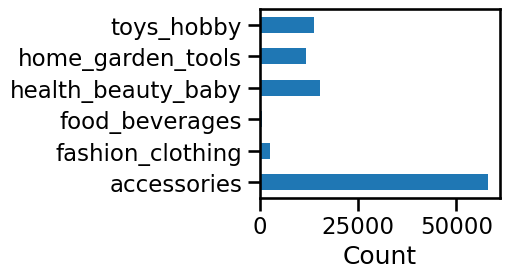

In [203]:
fig, ax = plt.subplots(figsize=(5, 3))
X.plot(kind="barh", ax=ax)
ax.set_ylabel("")
ax.set_xlabel("Count")
plt.gcf().subplots_adjust(left=0.50, bottom=0.25, right=0.98)
plt.savefig("./images/cat_products.png", dpi=300)
plt.show()

In [ ]:
sns.reset_defaults()
sns.set_theme()

Most purchases are _accessories_ products. What about the average _distribution_ per customer? 

In [138]:
data.head()

,frequency,purchase_recency,monetary_value,purchase_to_delivery_time,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,mean_nb_payment_types,mean_value_for_type,accessories,fashion_clothing,food_beverages,health_beauty_baby,home_garden_tools,toys_hobby,comment,no_comment
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,111,141.90,6.0,5.0,4.0,8.0,1.0,-0.461524,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,114,27.19,3.0,4.0,0.0,1.0,1.0,-0.366675,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
0000f46a3911fa3c0805444483337064,1,536,86.22,25.0,3.0,1.0,8.0,1.0,-0.531381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0000f6ccb0745a6a4b88665a16c9f078,1,320,43.62,20.0,4.0,1.0,4.0,1.0,-0.530177,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,1,287,196.89,13.0,5.0,4.0,6.0,1.0,-0.310167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<AxesSubplot:>

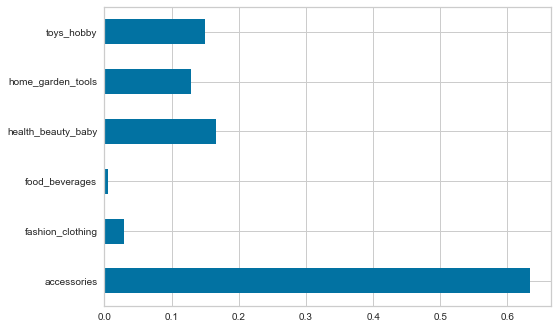

In [139]:
avg_customer_profile = data[category_columns].mean()
avg_customer_profile.plot(kind="barh")

The similarity between the two distributions hints at the fact that most customers purchased only once on the website.

## VIII.1 Uni- and bivariate distributions

In [206]:
cat_cols = data.columns[8:16]
num_cols = data.columns.drop(cat_cols)
X = data[num_cols]

<Figure size 720x720 with 0 Axes>

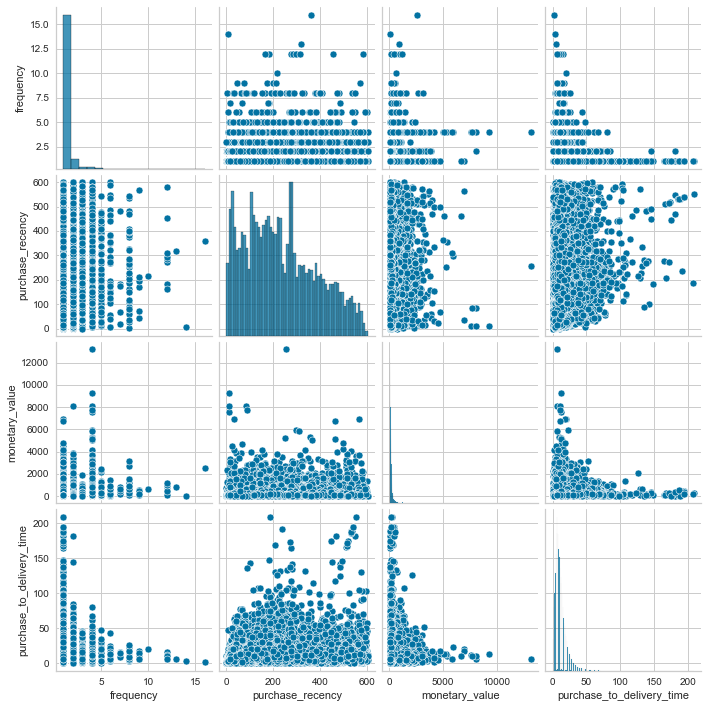

In [141]:
fig = plt.figure(figsize=(10, 10))
sns.pairplot(data=X[X.columns[:round(X.shape[1]/2)]])

<Figure size 720x720 with 0 Axes>

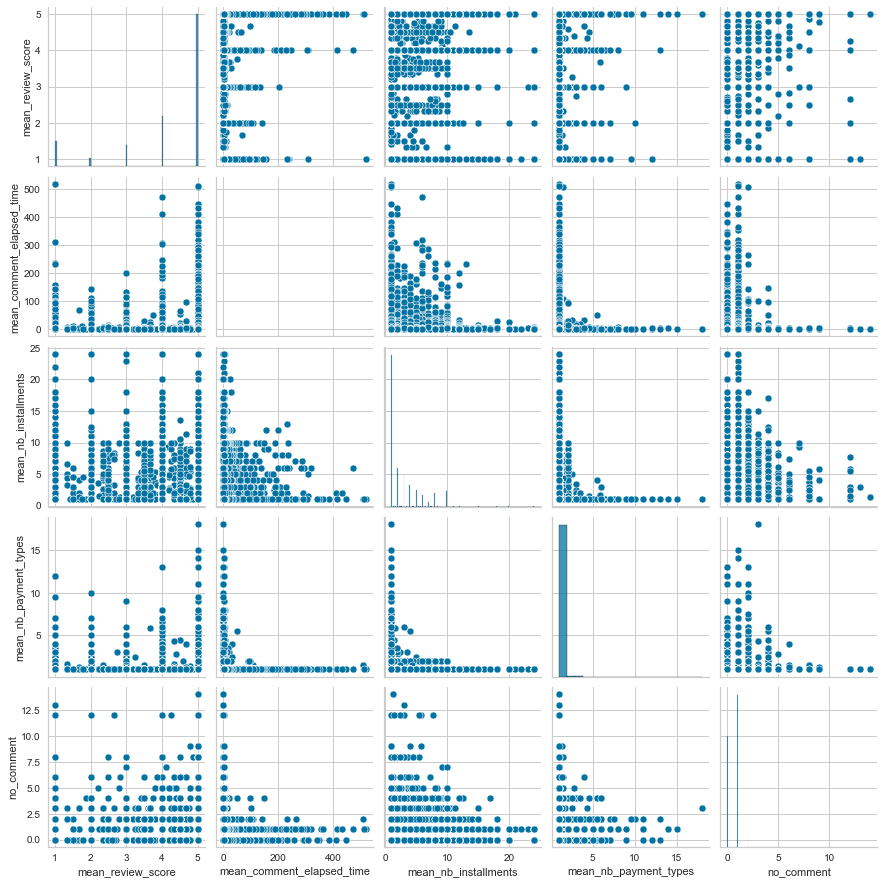

In [142]:
fig = plt.figure(figsize=(10, 10))
sns.pairplot(data=X[X.columns[round(X.shape[1]/2):]])

In [121]:
data.columns

Index(['frequency', 'purchase_recency', 'monetary_value',
       'purchase_to_delivery_time', 'mean_review_score',
       'mean_comment_elapsed_time', 'mean_nb_installments',
       'mean_nb_payment_types', 'mean_value_for_type', 'accessories',
       'fashion_clothing', 'food_beverages', 'health_beauty_baby',
       'home_garden_tools', 'toys_hobby', 'comment', 'no_comment'],
      dtype='object')

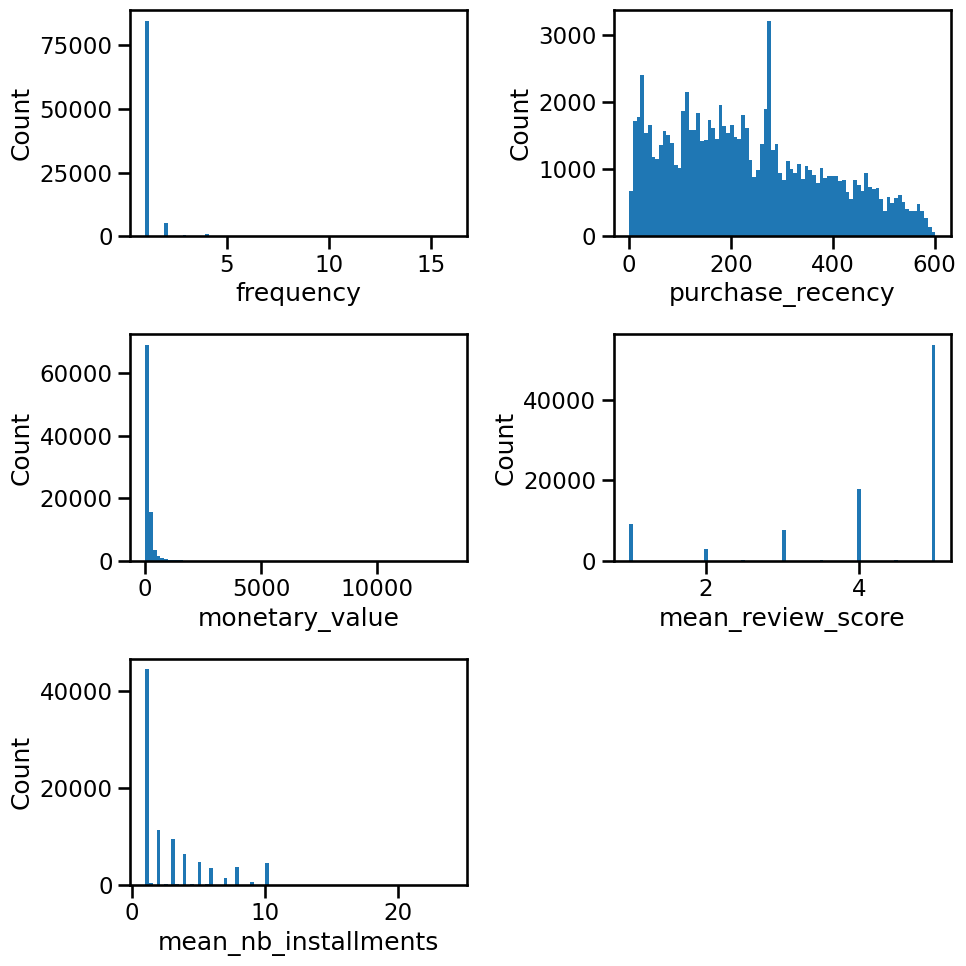

In [204]:
paircols = ["frequency", "purchase_recency","monetary_value",
            "mean_review_score", 
           "mean_nb_installments"]
fig = plt.figure(figsize=(10, 10))
for i, col in enumerate(paircols):
    ax = fig.add_subplot(3, 2, i+1)
    data[col].plot(kind='hist', bins=round(5*np.log2(data.shape[0])))
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.savefig("./images/exploration.png", dpi=300)
plt.show()


There are a few outliers. They are not necessarily incorrect data, but they might affect the quality of the clustering, therefore we choose to remove them

In [207]:
outliers_indices = pd.Index([])

for col in data.columns.drop(cat_cols):
    # outliers threshold
    out = data[col].quantile(0.99)
    
    # outliers indices
    outliers_indices = outliers_indices.append(data[data[col]>out].index)

data = data.drop(index=outliers_indices)

<Figure size 720x720 with 0 Axes>

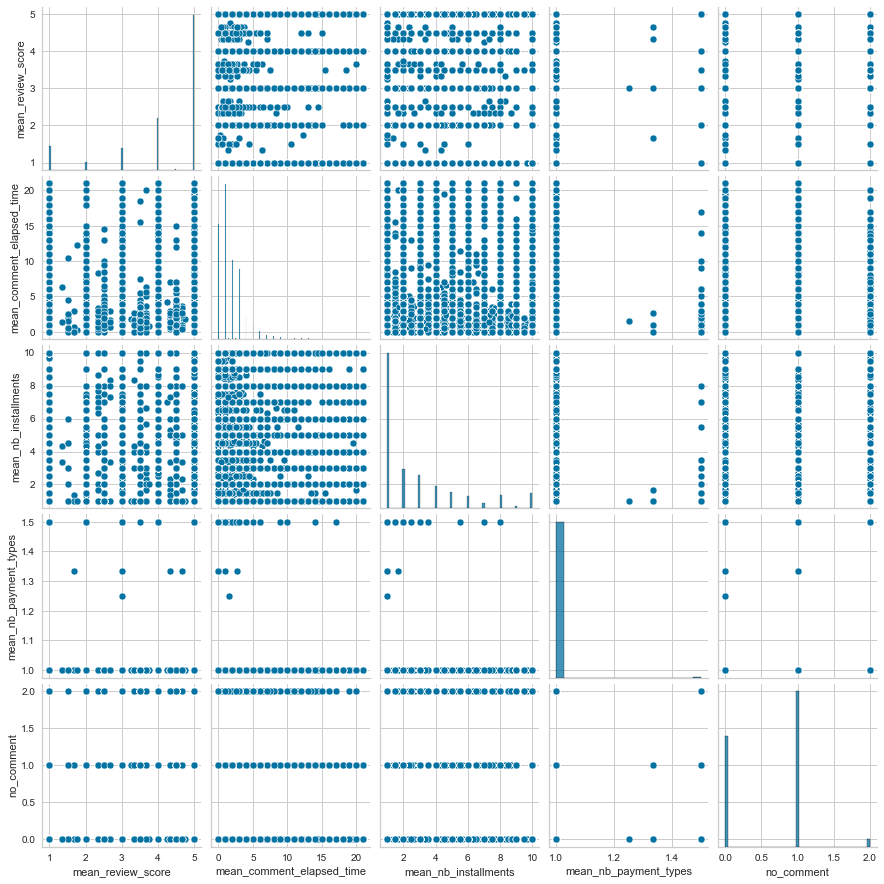

In [144]:
X_num = data[num_cols]

fig = plt.figure(figsize=(10, 10))
sns.pairplot(data=X_num[X_num.columns[round(X_num.shape[1]/2):]])

<AxesSubplot:xlabel='mean_comment_elapsed_time', ylabel='Count'>

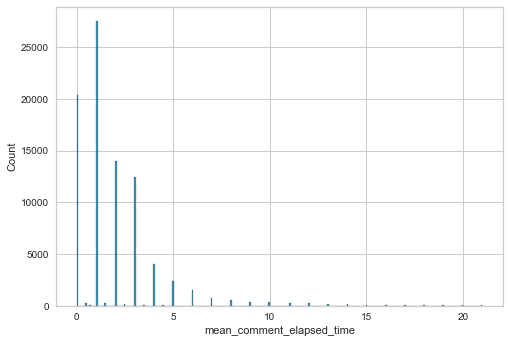

In [145]:
sns.histplot(data=data, x="mean_comment_elapsed_time")

## VIII.2 Correlations

In [210]:
sns.reset_defaults()
sns.set_theme()

<AxesSubplot:>

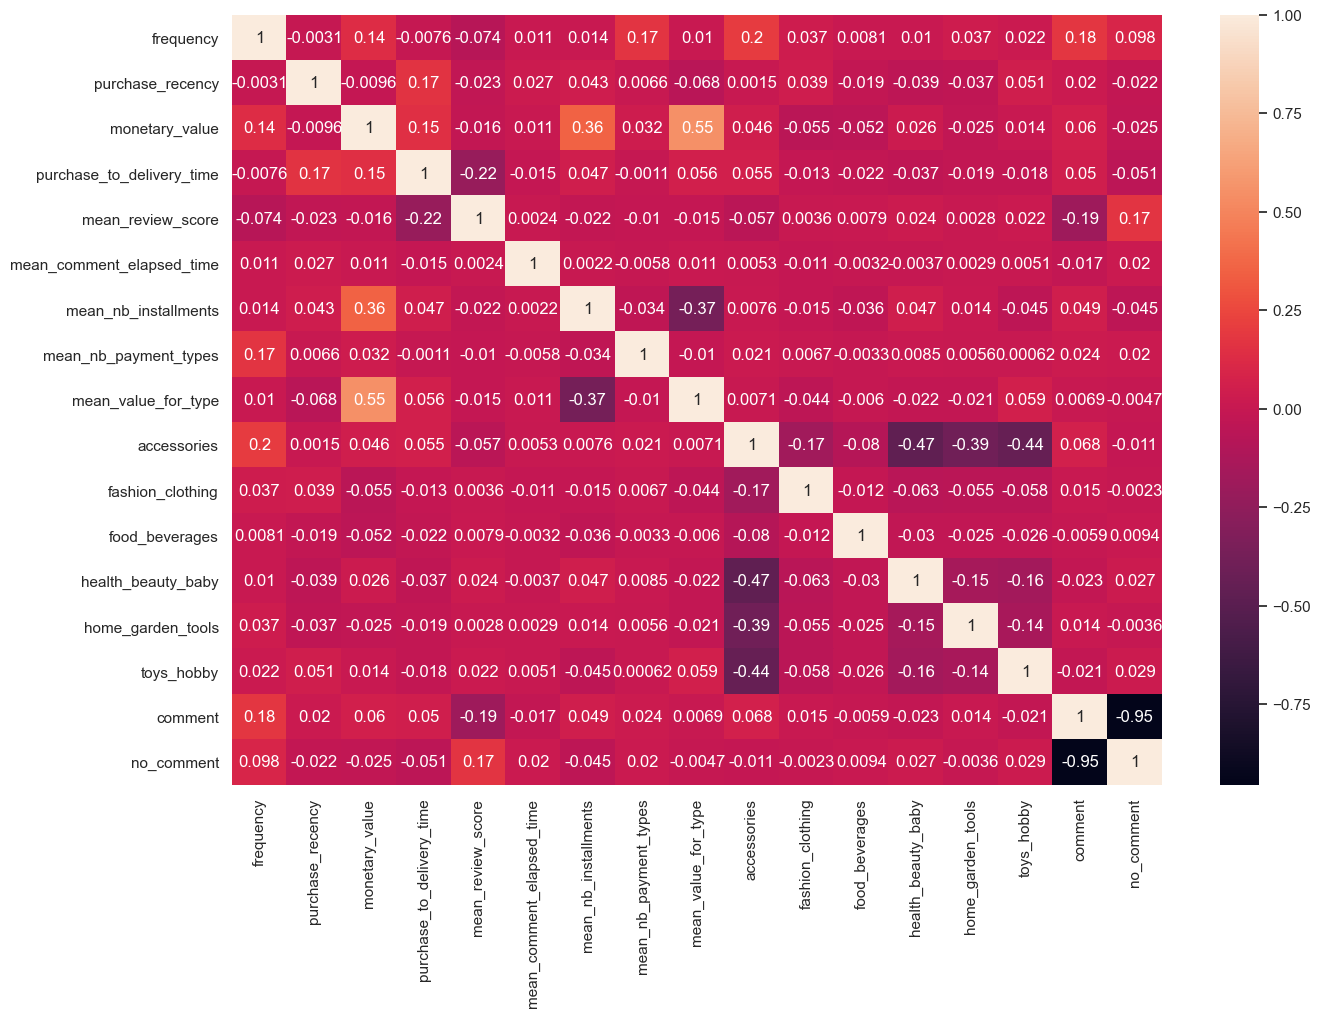

In [211]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(method='spearman'), annot=True)

A few interesting things from this heatmap of the linear correlations between variables:
- frequency is correlated with no_comment: people who buy more often are less likely to leave a comment
- frequency is also associated with accessories: when people buy several times, it is more likely to be in this category of products
- we have a negative association between mean_review_score and purchase_to_delivery_time: a higher delivery time is associated with poor review scores
- accessories is negatively associated with health_beauty_baby, home_garden_tools and toys_hobby. Peoply buying from accessories are less likely to buy from any of these three categories than from the food_beverages or fashion_clothing. (Accessories are watches, luggages, jewelry etc.)

In [214]:
sns.set_context("talk")

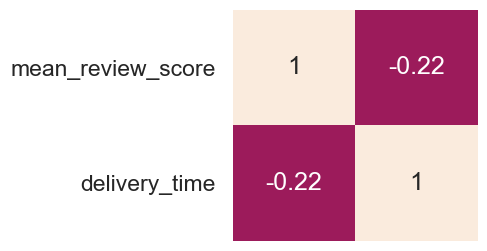

In [221]:
fig, ax = plt.subplots(figsize=(5, 3))
X = data[["mean_review_score", "purchase_to_delivery_time"]].rename(columns={"purchase_to_delivery_time":"delivery_time"})
sns.heatmap(X.corr(method='spearman'), annot=True, vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_xticklabels("")
plt.gcf().subplots_adjust(left=0.5, right=0.99)
plt.savefig("./images/review_delivery_corr.png", dpi=300)
plt.show()

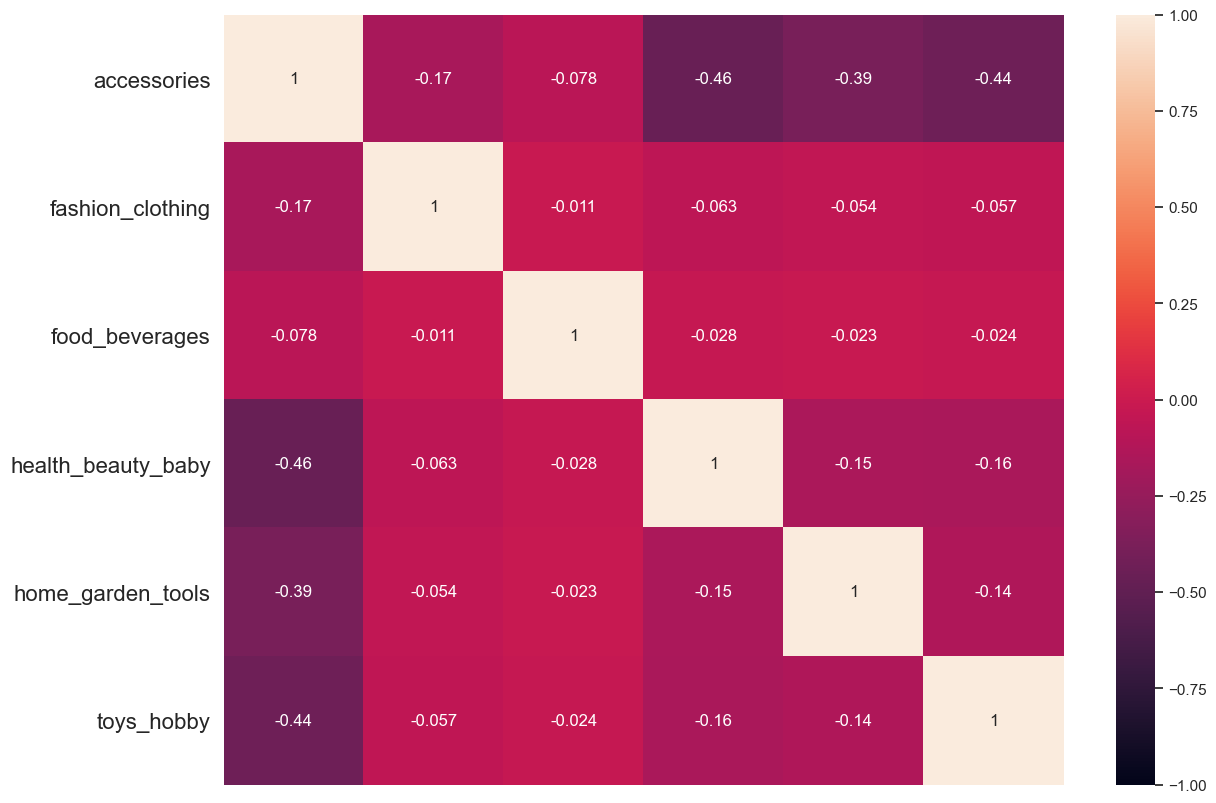

In [156]:
fig, ax = plt.subplots(figsize=(15, 10))
X = data[category_columns]
sns.heatmap(X.corr(method='spearman'), annot=True, vmin=-1, vmax=1, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_xticklabels("")
plt.gcf().subplots_adjust(left=0.2)
plt.savefig("./images/product_corr.png", dpi=300)
plt.show()

Notable correlations:
- "frequency", "monetary_value", "mean_nb_installments", "mean_value_for_type"
- product_columns ("accessories", "fashion_clothing", etc.)
- "frequency", "accessories"
- "comment", "no_comment"

In order to "uncorrelate" these variables without getting rid of the information they encode, we'll use one preprocessing method among the following:
- PCA
- NMF

## VIII.3 PCA on product category variables

**1. Defining new, uncorrelated product categories variables**

In [147]:
pd.Series(data.columns)

0                     frequency
1              purchase_recency
2                monetary_value
3     purchase_to_delivery_time
4             mean_review_score
5     mean_comment_elapsed_time
6          mean_nb_installments
7         mean_nb_payment_types
8           mean_value_for_type
9                   accessories
10             fashion_clothing
11               food_beverages
12           health_beauty_baby
13            home_garden_tools
14                   toys_hobby
15                      comment
16                   no_comment
dtype: object

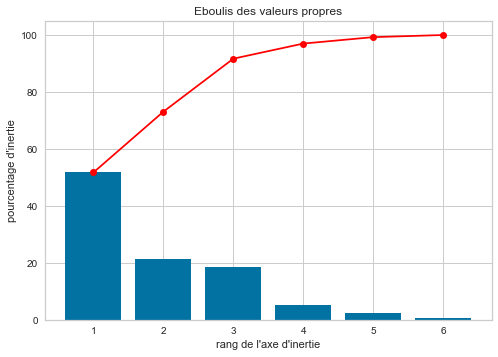


--> Inspection des 4 premières variables.

Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:


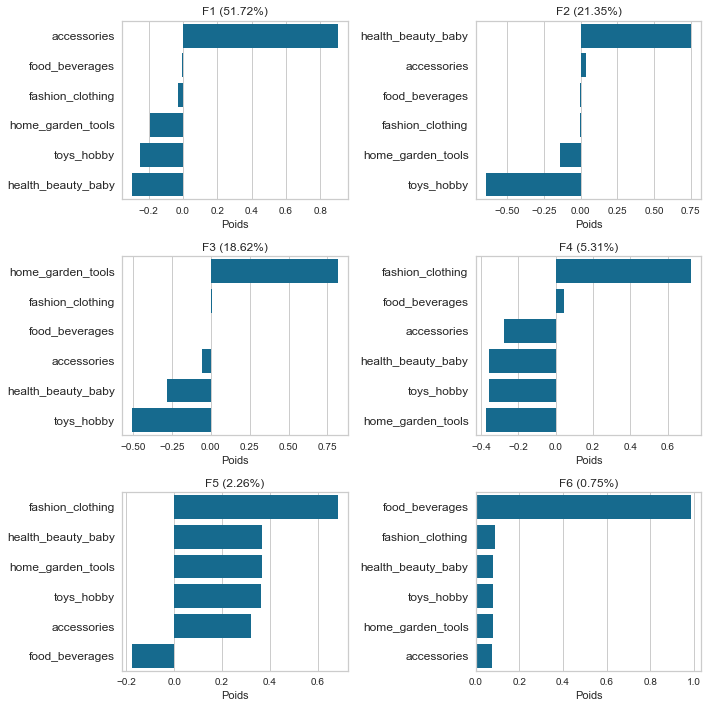

In [148]:
#1 PCA on the product categories variables
## préparation des données pour l'ACP ##
X = data[data.columns[9:15]].copy()
names = X.index 
features = X.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler(with_std=False).fit(X)
X_scaled = std_scale.transform(X)

## Calcul des composantes principales ##
pca = PCA()
pca.fit(X_scaled)

# Eboulis des valeurs propres
functions.display_scree_plot(pca, savefig=False)

print("")
print("--> Inspection des 4 premières variables.\n")

# Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes
pcacomponents = pd.DataFrame(data=np.transpose(pca.components_), 
                             columns=["F1", "F2", "F3", "F4", "F5", "F6"],
                             index=features)

pcacomponents = pcacomponents.reset_index().rename(columns={"index":"features"})

print("Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:")
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(pcacomponents.columns[1:]):
    ax = fig.add_subplot(3, 2, i+1)
    sns.barplot(data=pcacomponents.sort_values(by=c, ascending=False),
                x=c,
                y='features',
                color="b",
               ax=ax
               )
    ax.set_title("{} ({:.2f}%)".format(c, pca.explained_variance_ratio_[i]*100))
    ax.set_xlabel("Poids")
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    #plt.savefig('./pca_variables.png', dpi=300)
    plt.tight_layout()
plt.show()

We have "packages" of variables describing the data:
- "health_beauty_baby", "toys_hobby", "home_garden_tools": let us call it "care_renovation_hobby"
- "accessories",
- "fashion_clothing"

A higher F1 means:
- more accessories
- less "care_renovation_hobby"

A higher F2 means:
- more "health_beauty_baby"
- less "toys_hobby"
- less "home_garden_tools"
- more or less independant of the others

A higher F3 means:
- more "home_garden_tools"
- less "toys_hobby"
- less "health_beauty_baby"
- more or less independant of the others

A higher F4 means:
- more "fashion_clothing"
- less of the others except food_beverages (slight positive contribution)

Let us explore the kind of results we would get using NMF as the factorization algorithm

In [149]:
## préparation des données pour NMF ##
X = data[data.columns[9:15]].T.copy()
names = X.columns 
features = X.index

model = NMF(n_components=2).fit(X)
W = model.transform(X)
H = model.components_

Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:


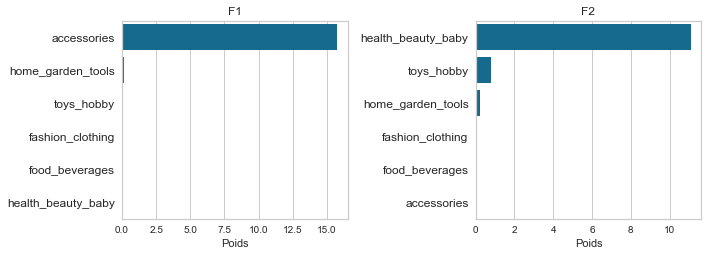

In [150]:
# Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes
nmfcomponents = pd.DataFrame(data=W, 
                             columns=["F1", 
                                      "F2",
                                      #"F3",
                                      #"F4",
                                      #"F5",
                                      #"F6"
                                     ],
                             index=features
                            )

nmfcomponents = nmfcomponents.reset_index().rename(columns={"index":"features"})

print("Affichage des poids des différentes variables dans les 4 nouvelles composantes les plus importantes:")
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(nmfcomponents.columns[1:]):
    ax = fig.add_subplot(3, 2, i+1)
    sns.barplot(data=nmfcomponents.sort_values(by=c, ascending=False),
                x=c,
                y='features',
                color="b",
               ax=ax
               )
    ax.set_title("{}".format(c))
    ax.set_xlabel("Poids")
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    #plt.savefig('./pca_variables.png', dpi=300)
    plt.tight_layout()
plt.show()

There is an almost one-to-one correspondance between each latent variable and each "visible" variable. The corresponding weights are probably linked to the the number of customers buying from one or the other category. Therefore this isn't very useful in our context.

In [151]:
#1 PCA on the product categories variables
## préparation des données pour l'ACP ##
X = data[data.columns[9:15]].copy()
names = X.index 
features = X.columns

# Centrage et Réduction
std_scaler = preprocessing.StandardScaler(with_std=False).fit(X)
X_scaled = std_scaler.transform(X)

## Calcul des composantes principales ##
pca = PCA(n_components=4)
X_pca = pd.DataFrame(data=pca.fit_transform(X_scaled), 
                     columns=["accessories+_care_renovation-",
                              "health+_toys-",
                              "home+_toysHealth-",
                              "fashion+_accesoriesCareRenov-",
                             ],
                     index=names
                    )

data = pd.concat((data.drop(columns=data.columns[9:15]), X_pca), axis=1)

The variable mean_nb_payment_types group almost all customers into a single category, therefore it isn't very relevant for our study, and we will not take it into consideration during the clustering. Besides this, the variables "monetary_value", "mean_nb_installments", and "mean_value_for_type" are correlated, therefore we choose to drop "mean_value_for_type" since it is somewhat redundant with the other two.

In [152]:
cols = ["mean_nb_payment_types", 'no_comment', 'mean_value_for_type']

for col in cols:
    try:
        data.drop(columns=col, inplace=True)
    except:
        pass

<AxesSubplot:>

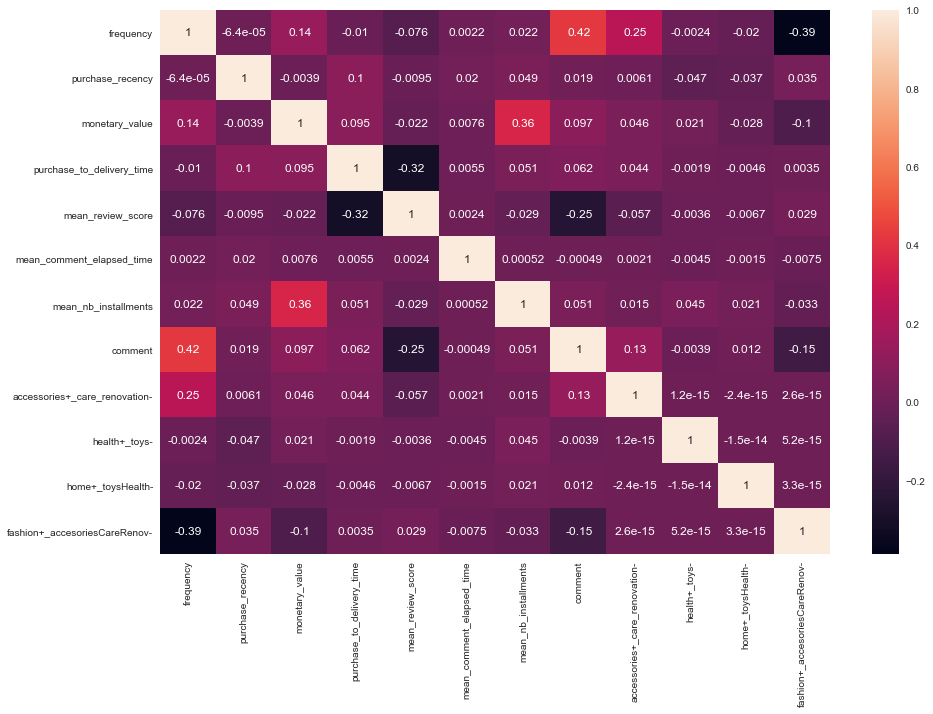

In [153]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(method='pearson'), annot=True)

### Save to csv

In [154]:
data.to_csv("./data/data.csv", index_label=False)